## make submissions using weighted rank avg based on the the oof

In [2]:
import sys
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

## define fast AUC

In [4]:
import numpy as np
from numba import jit


@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

## load models

In [5]:
ls ../mnt/blendings/2nd/

e091_e081_bin_change_0_10_2019-04-08-05-19-25_0.92396_oofs.csv
e091_e081_bin_change_0_10_2019-04-08-05-19-25_0.92396_oofs.pkl
e091_e081_bin_change_0_10_2019-04-08-05-19-25_0.92396_sub.csv.gz
e091_e081_bin_change_0_10_2019-04-08-05-19-25_0.92396_sub_no_rank.csv
nagiss_01_oof_CV_92065_LB_921.csv
nagiss_01_submission_CV_92065_LB_921.csv
nagiss_02_NN_oof_CV_92118.csv
nagiss_02_NN_submission_CV_92118.csv
oof_0.9237483.csv
oof_ra_x005_lgb_F1200_06.04.2019-10_58_roc0.923686_thr0.7545646.csv
sub_pa_x005_lgb_F1200_06.04.2019-10_58__0.923686_MCC0.599.csv
V600_0.9237483.csv


In [67]:
ls ../mnt/blendings/3rd/

e095_e081_bin_change_10_10_2019-04-09-10-09-32_0.9236_oofs.csv
e095_e081_bin_change_10_10_2019-04-09-10-09-32_0.9236_oofs.pkl
e095_e081_bin_change_10_10_2019-04-09-10-09-32_0.9236_sub_no_rank.csv
e095_e081_bin_change_10_10_2019-04-09-10-09-32_0.9236_sub_rank.csv.gz
exp_3_3_oof_pred.csv
exp_3_3_sub.csv
nagiss_02-2-2_NN_shuffle_rankavg_submission_CV_92386.csv*
nagiss_02-2_NN_shuffle_oof_CV_92386.csv
nagiss_02-2_NN_shuffle_submission_CV_92386.csv*
oof_0.9236922.csv
oof_0.9237644.csv
oof_0.923911.csv
oof_x030_lgb_F1200_09.04.2019-15.29_auc0.922451.csv
sub_pa_sub_x030_lgb_F1200_09.04.2019-15.29_CV0.922451.csv
sub_ra_sub_x030_lgb_F1200_09.04.2019-15.29_CV0.922451.csv
V400_0.923911_aver_rank.csv
V400_0.923911.csv
V600_0.9236922_aver_rank.csv
V600_0.9236922.csv
V600_0.9237644_aver_rank.csv
V600_0.9237644.csv


In [90]:
reals = np.load('../mnt/inputs/nes_info/real_samples_indexes.npz.npy')

# guchio best aug
guchio_oof = pd.read_csv('../mnt/blendings/2nd/e091_e081_bin_change_0_10_2019-04-08-05-19-25_0.92396_oofs.csv')
guchio_sub = pd.read_csv('../mnt/blendings/2nd/e091_e081_bin_change_0_10_2019-04-08-05-19-25_0.92396_sub.csv.gz')

# guchio 2nd best
guchio_2_oof = pd.read_csv('../mnt/blendings/3rd/e095_e081_bin_change_10_10_2019-04-09-10-09-32_0.9236_oofs.csv')
guchio_2_sub = pd.read_csv('../mnt/blendings/3rd/e095_e081_bin_change_10_10_2019-04-09-10-09-32_0.9236_sub_rank.csv.gz')

# graseck
graseck_oof = pd.read_csv('../mnt/blendings/3rd/oof_x030_lgb_F1200_09.04.2019-15.29_auc0.922451.csv')
graseck_oof = graseck_oof.set_index('ID_code').loc[guchio_oof.ID_code].reset_index()
graseck_sub = pd.read_csv('../mnt/blendings/3rd/sub_ra_sub_x030_lgb_F1200_09.04.2019-15.29_CV0.922451.csv')

# nagiss
naggis_oof = pd.read_csv('../mnt/blendings/2nd/nagiss_01_oof_CV_92065_LB_921.csv')
naggis_sub = pd.read_csv('../mnt/blendings/2nd/nagiss_01_submission_CV_92065_LB_921.csv')

# nagiss
naggis_rank_sub = pd.read_csv('../mnt/blendings/3rd/nagiss_01-2_lgbm_overfit_submission_rankavg_CV_92491_LB_922.csv')

# new nagiss nn
naggis_nn_2_oof = pd.read_csv('../mnt/blendings/3rd/nagiss_02-2_NN_shuffle_oof_CV_92386.csv')
naggis_nn_2_oof['oof_proba'] = naggis_nn_2_oof['pred']
# naggis_nn_2_sub = pd.read_csv('../mnt/blendings/3rd/nagiss_02-2-2_NN_shuffle_rankavg_submission_CV_92386.csv')
naggis_nn_2_sub = pd.read_csv('../mnt/blendings/3rd/nagiss_02-2_NN_shuffle_submission_CV_92386.csv')

# former nagiss nn
naggis_nn_oof = pd.read_csv('../mnt/blendings/2nd/nagiss_02_NN_oof_CV_92118.csv')
naggis_nn_oof['oof_proba'] = naggis_nn_2_oof['pred']
naggis_nn_sub = pd.read_csv('../mnt/blendings/2nd/nagiss_02_NN_submission_CV_92118.csv')

# vicens
vicens_oof = pd.read_csv('../mnt/blendings/3rd/oof_0.923911.csv')
vicens_oof['oof_proba'] = vicens_oof.p
vicens_sub = pd.read_csv('../mnt/blendings/3rd/V400_0.923911_aver_rank.csv')

# mamas
mamas_oof = pd.read_csv('../mnt/blendings/3rd/exp_3_3_oof_pred.csv')
mamas_oof['oof_proba'] = mamas_oof['oof_pred']
mamas_sub = pd.read_csv('../mnt/blendings/3rd/exp_3_3_sub.csv')
mamas_sub['target'] = mamas_sub['mean_pred']

In [92]:
pd.concat([naggis_rank_sub.iloc[reals].target, naggis_sub.iloc[reals]], axis=1).corr('spearman')

,target,target
target,1.000000,0.996058
target,0.996058,1.000000


In [72]:
mamas_sub.head()

,ID_code,rank_mean_pred,mean_pred
0,test_0,88817.000000,0.217668
1,test_1,68060.398438,0.066396
2,test_2,52993.000000,0.035042
3,test_3,45703.000000,0.026234
4,test_4,93872.000000,0.375783


In [31]:
# it is in the same order
(guchio_oof.ID_code.values == graseck_oof.ID_code.values).mean(), (guchio_oof.ID_code.values == vicens_oof.ID_code.values).mean(), (naggis_oof.ID_code.values == vicens_oof.ID_code.values).mean(), (guchio_oof.ID_code.values == naggis_nn_oof.ID_code.values).mean()

(1.0, 1.0, 1.0, 1.0)

In [26]:
# it is in the same order
(guchio_sub.ID_code.values == graseck_sub.ID_code.values).mean(), (guchio_sub.ID_code.values == vicens_sub.ID_code.values).mean(), (naggis_sub.ID_code.values == vicens_sub.ID_code.values).mean(), (guchio_sub.ID_code.values == naggis_nn_sub.ID_code.values).mean()

(1.0, 1.0, 1.0, 1.0)

In [75]:
def plot_oof_and_sub_hist(ax, oof_series, sub_series, reals):
    plt_sub = sub_series.iloc[reals]
    # sns.distplot(oof_series, kde=False, bins=100, ax=ax, color=None, label='oof', norm_hist=True, hist_kws={'alpha': 0.3})
    # sns.distplot(plt_sub, kde=False, bins=100, ax=ax, color='red', label='sub', norm_hist=True, hist_kws={'alpha': 0.3})
    sns.distplot(oof_series, kde=False, bins=100, ax=ax, color=None, label='oof', norm_hist=False, hist_kws={'alpha': 0.3})
    sns.distplot(plt_sub, kde=False, bins=100, ax=ax, color='red', label='sub', norm_hist=False, hist_kws={'alpha': 0.3})
    ax.set_xlim(0.0, 1.0)

In [14]:
naggis_nn_2_oof.head()

,ID_code,pred
0,train_0,0.000444
1,train_1,0.488474
2,train_2,0.003747
3,train_3,0.027369
4,train_4,0.062644


/root/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


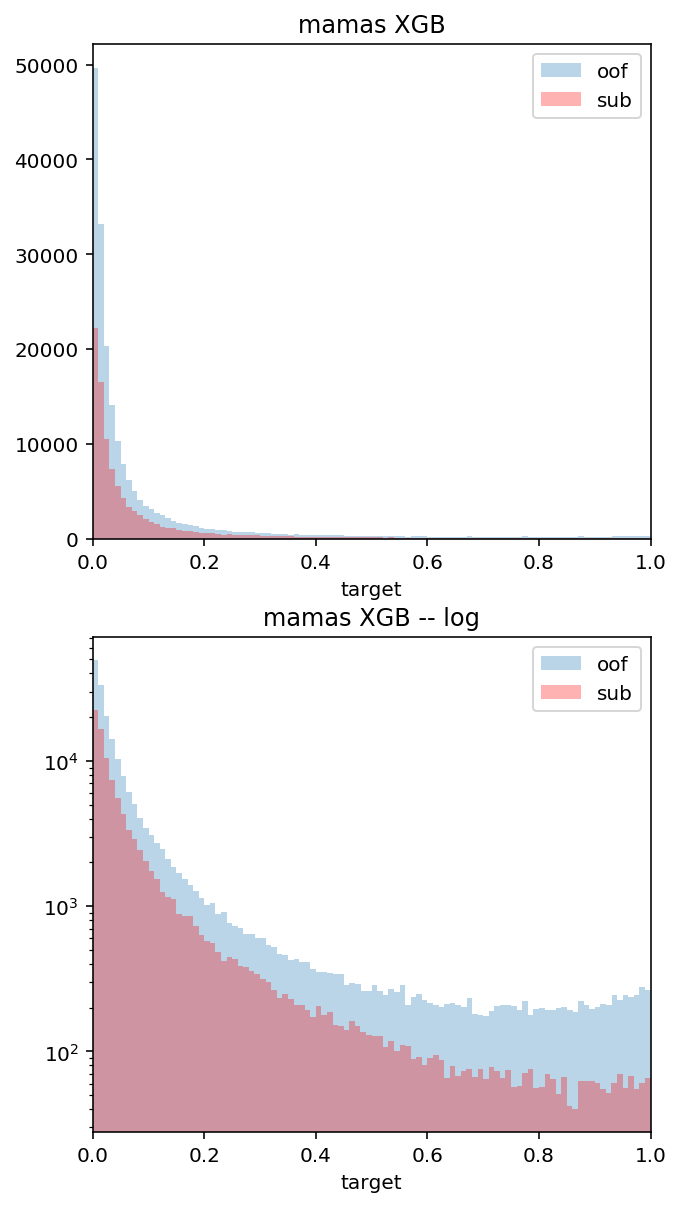

In [76]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

# nomalscale
# nagiss
ax = axs[0]
ax.set_title('mamas XGB')
plot_oof_and_sub_hist(ax, mamas_oof.oof_proba, mamas_sub.target, reals)
ax.legend()

## log scale
ax.legend()
# nagiss
ax = axs[1]
ax.set_yscale('log')
ax.set_title('mamas XGB -- log')
plot_oof_and_sub_hist(ax, mamas_oof.oof_proba, mamas_sub.target, reals)
ax.legend()

/root/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/root/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/root/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/root/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


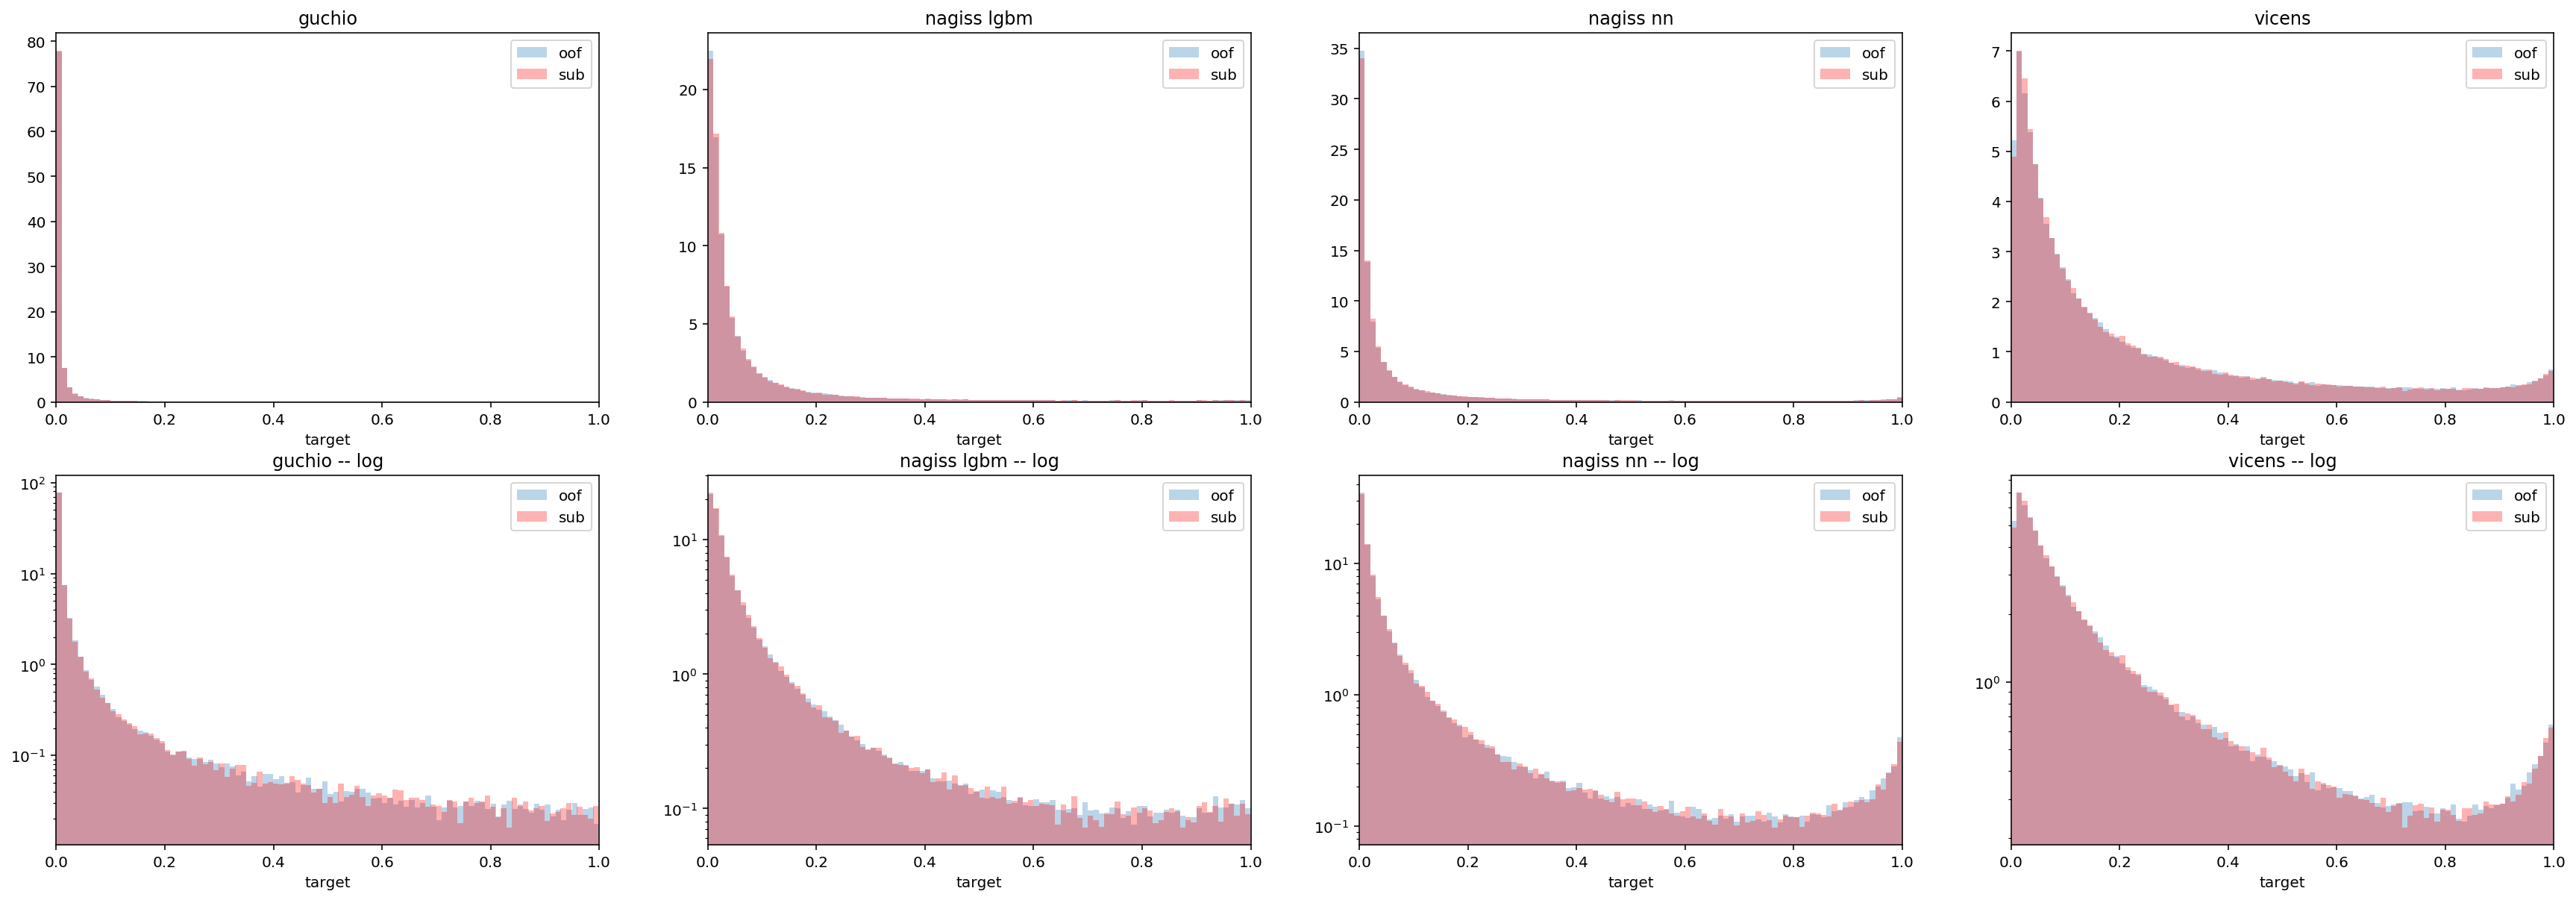

In [52]:
fig, axs = plt.subplots(2, 4, figsize=(30, 10))

# nomalscale
# guchio
ax = axs[0, 0]
ax.set_title('guchio')
plot_oof_and_sub_hist(ax, guchio_oof.oof_proba, guchio_sub.target, reals)
ax.legend()
# nagiss
ax = axs[0, 1]
ax.set_title('nagiss lgbm')
plot_oof_and_sub_hist(ax, naggis_oof.oof_proba, naggis_sub.target, reals)
ax.legend()
# nagiss
ax = axs[0, 2]
ax.set_title('nagiss nn')
plot_oof_and_sub_hist(ax, naggis_nn_oof.pred, naggis_nn_sub.target, reals)
ax.legend()
# vicens
ax = axs[0, 3]
ax.set_title('vicens')
plot_oof_and_sub_hist(ax, vicens_oof.oof_proba, vicens_sub.target, reals)
ax.legend()

## log scale
# guchio
ax = axs[1, 0]
ax.set_yscale('log')
ax.set_title('guchio -- log')
plot_oof_and_sub_hist(ax, guchio_oof.oof_proba, guchio_sub.target, reals)
ax.legend()
# nagiss
ax = axs[1, 1]
ax.set_yscale('log')
ax.set_title('nagiss lgbm -- log')
plot_oof_and_sub_hist(ax, naggis_oof.oof_proba, naggis_sub.target, reals)
ax.legend()
# nagiss nn 
ax = axs[1, 2]
ax.set_yscale('log')
ax.set_title('nagiss nn -- log')
plot_oof_and_sub_hist(ax, naggis_nn_oof.pred, naggis_nn_sub.target, reals)
ax.legend()
# vicens
ax = axs[1, 3]
ax.set_yscale('log')
ax.set_title('vicens -- log')
plot_oof_and_sub_hist(ax, vicens_oof.oof_proba, vicens_sub.target, reals)
ax.legend()

## linear mean double check

In [50]:
# grass, guchio_lower, guchio_higher, nag, nag nn1, nag nn2, vic
weight_matrix = np.array([[0.3639757,1.5434195,0.2185098, 1.7741122, 1.7739575, 3.6596243, 1.9862587],
[0.3705904, 1.4345907, 0.4968160, 1.8552535, 1.5552508, 3.7553267, 1.8166311],
[0.1858702, 1.5881663, 0.2804491, 1.8228344, 1.6447991, 3.7809418, 1.9129553],
[0.1477555, 1.5685645, 0.3251145, 1.8169258, 1.4151735, 4.0227342, 2.0434625],
[0.4703706, 1.4781933, 0.5402226, 1.6681665, 1.3678758, 4.0474648, 1.7697711],
[0.2773039, 1.5090743, 0.4572026, 1.8053519, 1.6617647, 3.6851305, 1.9441000],
[0.4043304, 1.4884742, 0.3762892, 1.8121635, 1.6036811, 3.8292705, 1.7685845],
[0.4701455, 1.4841568, 0.4827251, 1.6294444, 1.6967531, 3.7669447, 1.8197271],
[0.5332939, 1.5856507, 0.4150513, 1.7093402, 1.5408974, 3.7944788, 1.6966927],
[0.2141903, 1.6118834, 0.3784598, 1.7895871, 1.5897705, 3.7114288, 2.0031331],])

In [52]:
meaned_weight = weight_matrix.mean(axis=0)
meaned_weight

array([0.34378264, 1.52921737, 0.397084  , 1.76831795, 1.58499235,
       3.80533451, 1.87613161])

In [54]:
res = (
    (graseck_oof['rank_oof_proba'] * meaned_weight[0]) +\
    (guchio_2_oof['rank_oof_proba'] * meaned_weight[1]) +\
    (guchio_oof['rank_oof_proba'] * meaned_weight[2]) +\
    (naggis_oof['rank_oof_proba'] * meaned_weight[3]) +\
    (naggis_nn_oof['rank_oof_proba'] * meaned_weight[4]) +\
    (naggis_nn_2_oof['rank_oof_proba'] * meaned_weight[5]) +\
    (vicens_oof['rank_oof_proba'] * meaned_weight[6]) ) / np.sum(meaned_weight)

In [55]:
roc_auc_score(guchio_oof.y_val, res)

0.9260564490901123

In [79]:
mamas_oof.tail()

,ID_code,oof_pred,oof_proba,rank_oof_proba
199995,train_199995,0.047029,0.047029,0.623625
199996,train_199996,0.030625,0.030625,0.520005
199997,train_199997,0.062124,0.062124,0.683565
199998,train_199998,0.023007,0.023007,0.447880
199999,train_199999,0.003995,0.003995,0.088895


### mamas-kun の XGB 試す

In [94]:
guchio_sub['rank_sub_proba'] = guchio_sub.target.rank() / len(guchio_sub)
guchio_2_sub['rank_sub_proba'] = guchio_2_sub.target.rank() / len(guchio_sub)
graseck_sub['rank_sub_proba'] = graseck_sub.target.rank() / len(guchio_sub)
naggis_sub['rank_sub_proba'] = naggis_sub.target.rank() / len(guchio_sub)
naggis_rank_sub['rank_sub_proba'] = naggis_rank_sub.target.rank() / len(guchio_sub)
naggis_nn_2_sub['rank_sub_proba'] = naggis_nn_2_sub.target.rank() / len(guchio_sub)
naggis_nn_sub['rank_sub_proba'] = naggis_nn_sub.target.rank() / len(guchio_sub)
vicens_sub['rank_sub_proba'] = vicens_sub.target.rank() / len(guchio_sub)
mamas_sub['rank_sub_proba'] = mamas_sub.target.rank() / len(guchio_sub)

In [99]:
weight = [1, 9, 7, 6, 9, 9, 9]
res = (graseck_sub.rank_sub_proba  * weight[0] + guchio_sub.rank_sub_proba * weights[1] + guchio_2_sub.rank_sub_proba * weights[2] + naggis_rank_sub.rank_sub_proba * weight[3] +  naggis_nn_sub.rank_sub_proba * weight[4] +  naggis_nn_2_sub.rank_sub_proba * weight[5] + vicens_sub.rank_sub_proba * weights[6]) / np.sum(weight)



In [100]:
res

0         0.534957
1         0.626231
2         0.624215
3         0.863535
4         0.505113
5         0.094255
6         0.108392
7         0.790567
8         0.087828
9         0.155731
10        0.647209
11        0.728996
12        0.422321
13        0.417844
14        0.094195
15        0.597490
16        0.948908
17        0.578115
18        0.781052
19        0.156224
20        0.961634
21        0.592641
22        0.440250
23        0.320764
24        0.398598
25        0.442823
26        0.547709
27        0.277160
28        0.636317
29        0.597392
30        0.382958
31        0.395968
32        0.740245
33        0.619455
34        0.528550
35        0.316416
36        0.252676
37        0.365245
38        0.210273
39        0.877789
40        0.246560
41        0.077852
42        0.467446
43        0.377095
44        0.584758
45        0.403488
46        0.437122
47        0.317708
48        0.399050
49        0.206379
50        0.916607
51        0.197343
52        0.

In [102]:
naggis_rank_sub.head()

,ID_code,target,rank_sub_proba
0,test_0,0.699774,0.707090
1,test_1,0.803502,0.811875
2,test_2,0.917866,0.923080
3,test_3,0.847007,0.854585
4,test_4,0.716371,0.724510


In [103]:
res_sub = guchio_sub.copy().drop('rank_sub_proba', axis=1)
res_sub.head()

,ID_code,target
0,test_0,0.008703
1,test_1,0.024498
2,test_2,0.027850
3,test_3,0.801616
4,test_4,0.008131


In [104]:
res_sub['target'] = res
res_sub.head()

,ID_code,target
0,test_0,0.534957
1,test_1,0.626231
2,test_2,0.624215
3,test_3,0.863535
4,test_4,0.505113


In [105]:
res_sub.to_csv('../mnt/submissions/1_9_7_9_9_9_w_naggis_rank.csv', index=False)

In [85]:
best_AUC = 0.0
best_weight = [0, 0, 0]

weight = [1, 9, 7, 6, 9, 9, 9]
res = graseck_oof.rank_oof_proba  * weight[0] + guchio_oof.rank_oof_proba * weights[1] + guchio_2_oof.rank_oof_proba * weights[2] + naggis_oof.rank_oof_proba * weight[3] +  naggis_nn_oof.rank_oof_proba * weight[4] +  naggis_nn_2_oof.rank_oof_proba * weight[5] + vicens_oof.rank_oof_proba * weights[6]

for i in tqdm(list(np.arange(0, 99))):
    mamas_weight = i / 10
    rank_avg_pred = (res + mamas_oof.rank_oof_proba * mamas_weight) / (np.sum(weights) + mamas_weight)
    auc = fast_auc(guchio_oof.y_val, rank_avg_pred)
    if auc > best_AUC:
        best_AUC = auc
        best_weight = [mamas_weight]
    print(f'AUC: {auc:.5}, mamas: {mamas_weight}')
    
    
    

AUC: 0.92608, mamas: 0.0
AUC: 0.92608, mamas: 0.1
AUC: 0.92609, mamas: 0.2
AUC: 0.92609, mamas: 0.3
AUC: 0.92609, mamas: 0.4
AUC: 0.92609, mamas: 0.5
AUC: 0.92609, mamas: 0.6
AUC: 0.92609, mamas: 0.7
AUC: 0.92609, mamas: 0.8
AUC: 0.92609, mamas: 0.9
AUC: 0.92609, mamas: 1.0
AUC: 0.92609, mamas: 1.1
AUC: 0.92609, mamas: 1.2
AUC: 0.92609, mamas: 1.3
AUC: 0.92609, mamas: 1.4
AUC: 0.92609, mamas: 1.5
AUC: 0.92609, mamas: 1.6
AUC: 0.92609, mamas: 1.7
AUC: 0.92609, mamas: 1.8
AUC: 0.92609, mamas: 1.9
AUC: 0.92609, mamas: 2.0
AUC: 0.92609, mamas: 2.1
AUC: 0.92609, mamas: 2.2
AUC: 0.92609, mamas: 2.3
AUC: 0.92609, mamas: 2.4
AUC: 0.92609, mamas: 2.5
AUC: 0.92608, mamas: 2.6
AUC: 0.92608, mamas: 2.7
AUC: 0.92608, mamas: 2.8
AUC: 0.92608, mamas: 2.9
AUC: 0.92608, mamas: 3.0
AUC: 0.92608, mamas: 3.1
AUC: 0.92608, mamas: 3.2
AUC: 0.92608, mamas: 3.3
AUC: 0.92608, mamas: 3.4
AUC: 0.92608, mamas: 3.5
AUC: 0.92608, mamas: 3.6
AUC: 0.92608, mamas: 3.7
AUC: 0.92607, mamas: 3.8
AUC: 0.92607, mamas: 3.9


In [87]:
best_AUC

0.9260881945169429

In [77]:
guchio_oof['rank_oof_proba'] = guchio_oof.oof_proba.rank() / len(guchio_oof)
guchio_2_oof['rank_oof_proba'] = guchio_2_oof.oof_proba.rank() / len(guchio_oof)
graseck_oof['rank_oof_proba'] = graseck_oof.oof_proba.rank() / len(guchio_oof)
naggis_oof['rank_oof_proba'] = naggis_oof.oof_proba.rank() / len(guchio_oof)
naggis_nn_2_oof['rank_oof_proba'] = naggis_nn_2_oof.oof_proba.rank() / len(guchio_oof)
naggis_nn_oof['rank_oof_proba'] = naggis_nn_oof.oof_proba.rank() / len(guchio_oof)
vicens_oof['rank_oof_proba'] = vicens_oof.oof_proba.rank() / len(guchio_oof)
mamas_oof['rank_oof_proba'] = mamas_oof.oof_proba.rank() / len(guchio_oof)

In [33]:
a = pd.concat([guchio_sub.target.iloc[reals], guchio_2_sub.target.iloc[reals]], axis=1)
a.columns = ['guchio', 'guchio 2']
a.corr('spearman')

,guchio,guchio 2
guchio,1.000000,0.994787
guchio 2,0.994787,1.000000


In [47]:
best_AUC = 0.0
best_weight = [0, 0, 0]

for guchio_weight in tqdm(list(range(10))):
    for naggis_weight in range(10):
        for vicens_weight in range(10):
            if guchio_weight + naggis_weight + vicens_weight == 0:
                continue
            rank_avg_pred = ((guchio_weight * guchio_oof.rank_oof_proba) + \
                                           (naggis_weight * naggis_nn_oof.rank_oof_proba) + \
                                           # (naggis_weight * naggis_oof.oof_proba.rank() / len(guchio_oof)) + \
                                           (vicens_weight * vicens_oof.rank_oof_proba)) / (guchio_weight + naggis_weight + vicens_weight)
            auc = fast_auc(guchio_oof.y_val, rank_avg_pred)
            # auc = roc_auc_score(guchio_oof.y_val, rank_avg_pred)
            if auc > best_AUC:
                best_AUC = auc
                best_weight = [guchio_weight, naggis_weight, vicens_weight]
            print(f'AUC: {auc:.5}, guchio: {guchio_weight}, nagiss: {naggis_weight}, vicens_weight: {vicens_weight}')

AUC: 0.92391, guchio: 0, nagiss: 0, vicens_weight: 1
AUC: 0.92391, guchio: 0, nagiss: 0, vicens_weight: 2
AUC: 0.92391, guchio: 0, nagiss: 0, vicens_weight: 3
AUC: 0.92391, guchio: 0, nagiss: 0, vicens_weight: 4
AUC: 0.92391, guchio: 0, nagiss: 0, vicens_weight: 5
AUC: 0.92391, guchio: 0, nagiss: 0, vicens_weight: 6
AUC: 0.92391, guchio: 0, nagiss: 0, vicens_weight: 7
AUC: 0.92391, guchio: 0, nagiss: 0, vicens_weight: 8
AUC: 0.92391, guchio: 0, nagiss: 0, vicens_weight: 9
AUC: 0.92386, guchio: 0, nagiss: 1, vicens_weight: 0
AUC: 0.9259, guchio: 0, nagiss: 1, vicens_weight: 1
AUC: 0.92569, guchio: 0, nagiss: 1, vicens_weight: 2
AUC: 0.92542, guchio: 0, nagiss: 1, vicens_weight: 3
AUC: 0.9252, guchio: 0, nagiss: 1, vicens_weight: 4
AUC: 0.92504, guchio: 0, nagiss: 1, vicens_weight: 5
AUC: 0.9249, guchio: 0, nagiss: 1, vicens_weight: 6
AUC: 0.9248, guchio: 0, nagiss: 1, vicens_weight: 7
AUC: 0.92471, guchio: 0, nagiss: 1, vicens_weight: 8
AUC: 0.92464, guchio: 0, nagiss: 1, vicens_weight:

AUC: 0.92569, guchio: 1, nagiss: 6, vicens_weight: 2
AUC: 0.92587, guchio: 1, nagiss: 6, vicens_weight: 3
AUC: 0.92595, guchio: 1, nagiss: 6, vicens_weight: 4
AUC: 0.92598, guchio: 1, nagiss: 6, vicens_weight: 5
AUC: 0.92598, guchio: 1, nagiss: 6, vicens_weight: 6
AUC: 0.92596, guchio: 1, nagiss: 6, vicens_weight: 7
AUC: 0.92593, guchio: 1, nagiss: 6, vicens_weight: 8
AUC: 0.92589, guchio: 1, nagiss: 6, vicens_weight: 9
AUC: 0.92465, guchio: 1, nagiss: 7, vicens_weight: 0
AUC: 0.92523, guchio: 1, nagiss: 7, vicens_weight: 1
AUC: 0.92558, guchio: 1, nagiss: 7, vicens_weight: 2
AUC: 0.92578, guchio: 1, nagiss: 7, vicens_weight: 3
AUC: 0.92589, guchio: 1, nagiss: 7, vicens_weight: 4
AUC: 0.92595, guchio: 1, nagiss: 7, vicens_weight: 5
AUC: 0.92598, guchio: 1, nagiss: 7, vicens_weight: 6
AUC: 0.92598, guchio: 1, nagiss: 7, vicens_weight: 7
AUC: 0.92596, guchio: 1, nagiss: 7, vicens_weight: 8
AUC: 0.92593, guchio: 1, nagiss: 7, vicens_weight: 9
AUC: 0.92457, guchio: 1, nagiss: 8, vicens_wei

AUC: 0.92587, guchio: 3, nagiss: 2, vicens_weight: 2
AUC: 0.92582, guchio: 3, nagiss: 2, vicens_weight: 3
AUC: 0.92575, guchio: 3, nagiss: 2, vicens_weight: 4
AUC: 0.92567, guchio: 3, nagiss: 2, vicens_weight: 5
AUC: 0.92558, guchio: 3, nagiss: 2, vicens_weight: 6
AUC: 0.9255, guchio: 3, nagiss: 2, vicens_weight: 7
AUC: 0.92542, guchio: 3, nagiss: 2, vicens_weight: 8
AUC: 0.92535, guchio: 3, nagiss: 2, vicens_weight: 9
AUC: 0.92569, guchio: 3, nagiss: 3, vicens_weight: 0
AUC: 0.92592, guchio: 3, nagiss: 3, vicens_weight: 1
AUC: 0.92599, guchio: 3, nagiss: 3, vicens_weight: 2
AUC: 0.92598, guchio: 3, nagiss: 3, vicens_weight: 3
AUC: 0.92593, guchio: 3, nagiss: 3, vicens_weight: 4
AUC: 0.92587, guchio: 3, nagiss: 3, vicens_weight: 5
AUC: 0.9258, guchio: 3, nagiss: 3, vicens_weight: 6
AUC: 0.92572, guchio: 3, nagiss: 3, vicens_weight: 7
AUC: 0.92565, guchio: 3, nagiss: 3, vicens_weight: 8
AUC: 0.92558, guchio: 3, nagiss: 3, vicens_weight: 9
AUC: 0.92564, guchio: 3, nagiss: 4, vicens_weigh

AUC: 0.92585, guchio: 4, nagiss: 8, vicens_weight: 2
AUC: 0.92595, guchio: 4, nagiss: 8, vicens_weight: 3
AUC: 0.92601, guchio: 4, nagiss: 8, vicens_weight: 4
AUC: 0.92604, guchio: 4, nagiss: 8, vicens_weight: 5
AUC: 0.92605, guchio: 4, nagiss: 8, vicens_weight: 6
AUC: 0.92605, guchio: 4, nagiss: 8, vicens_weight: 7
AUC: 0.92604, guchio: 4, nagiss: 8, vicens_weight: 8
AUC: 0.92601, guchio: 4, nagiss: 8, vicens_weight: 9
AUC: 0.9254, guchio: 4, nagiss: 9, vicens_weight: 0
AUC: 0.92564, guchio: 4, nagiss: 9, vicens_weight: 1
AUC: 0.9258, guchio: 4, nagiss: 9, vicens_weight: 2
AUC: 0.92591, guchio: 4, nagiss: 9, vicens_weight: 3
AUC: 0.92598, guchio: 4, nagiss: 9, vicens_weight: 4
AUC: 0.92602, guchio: 4, nagiss: 9, vicens_weight: 5
AUC: 0.92604, guchio: 4, nagiss: 9, vicens_weight: 6
AUC: 0.92605, guchio: 4, nagiss: 9, vicens_weight: 7
AUC: 0.92605, guchio: 4, nagiss: 9, vicens_weight: 8
AUC: 0.92603, guchio: 4, nagiss: 9, vicens_weight: 9
AUC: 0.92396, guchio: 5, nagiss: 0, vicens_weigh

AUC: 0.92577, guchio: 6, nagiss: 4, vicens_weight: 1
AUC: 0.92584, guchio: 6, nagiss: 4, vicens_weight: 2
AUC: 0.92587, guchio: 6, nagiss: 4, vicens_weight: 3
AUC: 0.92587, guchio: 6, nagiss: 4, vicens_weight: 4
AUC: 0.92585, guchio: 6, nagiss: 4, vicens_weight: 5
AUC: 0.92582, guchio: 6, nagiss: 4, vicens_weight: 6
AUC: 0.92579, guchio: 6, nagiss: 4, vicens_weight: 7
AUC: 0.92575, guchio: 6, nagiss: 4, vicens_weight: 8
AUC: 0.92571, guchio: 6, nagiss: 4, vicens_weight: 9
AUC: 0.92568, guchio: 6, nagiss: 5, vicens_weight: 0
AUC: 0.92582, guchio: 6, nagiss: 5, vicens_weight: 1
AUC: 0.9259, guchio: 6, nagiss: 5, vicens_weight: 2
AUC: 0.92594, guchio: 6, nagiss: 5, vicens_weight: 3
AUC: 0.92595, guchio: 6, nagiss: 5, vicens_weight: 4
AUC: 0.92594, guchio: 6, nagiss: 5, vicens_weight: 5
AUC: 0.92592, guchio: 6, nagiss: 5, vicens_weight: 6
AUC: 0.92589, guchio: 6, nagiss: 5, vicens_weight: 7
AUC: 0.92586, guchio: 6, nagiss: 5, vicens_weight: 8
AUC: 0.92582, guchio: 6, nagiss: 5, vicens_weig

AUC: 0.92603, guchio: 7, nagiss: 9, vicens_weight: 6
AUC: 0.92603, guchio: 7, nagiss: 9, vicens_weight: 7
AUC: 0.92603, guchio: 7, nagiss: 9, vicens_weight: 8
AUC: 0.92602, guchio: 7, nagiss: 9, vicens_weight: 9
AUC: 0.92396, guchio: 8, nagiss: 0, vicens_weight: 0
AUC: 0.92429, guchio: 8, nagiss: 0, vicens_weight: 1
AUC: 0.9245, guchio: 8, nagiss: 0, vicens_weight: 2
AUC: 0.92462, guchio: 8, nagiss: 0, vicens_weight: 3
AUC: 0.9247, guchio: 8, nagiss: 0, vicens_weight: 4
AUC: 0.92474, guchio: 8, nagiss: 0, vicens_weight: 5
AUC: 0.92477, guchio: 8, nagiss: 0, vicens_weight: 6
AUC: 0.92478, guchio: 8, nagiss: 0, vicens_weight: 7
AUC: 0.92478, guchio: 8, nagiss: 0, vicens_weight: 8
AUC: 0.92478, guchio: 8, nagiss: 0, vicens_weight: 9
AUC: 0.92466, guchio: 8, nagiss: 1, vicens_weight: 0
AUC: 0.92488, guchio: 8, nagiss: 1, vicens_weight: 1
AUC: 0.925, guchio: 8, nagiss: 1, vicens_weight: 2
AUC: 0.92508, guchio: 8, nagiss: 1, vicens_weight: 3
AUC: 0.92511, guchio: 8, nagiss: 1, vicens_weight:

AUC: 0.92577, guchio: 9, nagiss: 5, vicens_weight: 3
AUC: 0.92579, guchio: 9, nagiss: 5, vicens_weight: 4
AUC: 0.9258, guchio: 9, nagiss: 5, vicens_weight: 5
AUC: 0.92579, guchio: 9, nagiss: 5, vicens_weight: 6
AUC: 0.92578, guchio: 9, nagiss: 5, vicens_weight: 7
AUC: 0.92576, guchio: 9, nagiss: 5, vicens_weight: 8
AUC: 0.92574, guchio: 9, nagiss: 5, vicens_weight: 9
AUC: 0.92563, guchio: 9, nagiss: 6, vicens_weight: 0
AUC: 0.92573, guchio: 9, nagiss: 6, vicens_weight: 1
AUC: 0.9258, guchio: 9, nagiss: 6, vicens_weight: 2
AUC: 0.92584, guchio: 9, nagiss: 6, vicens_weight: 3
AUC: 0.92586, guchio: 9, nagiss: 6, vicens_weight: 4
AUC: 0.92587, guchio: 9, nagiss: 6, vicens_weight: 5
AUC: 0.92587, guchio: 9, nagiss: 6, vicens_weight: 6
AUC: 0.92586, guchio: 9, nagiss: 6, vicens_weight: 7
AUC: 0.92585, guchio: 9, nagiss: 6, vicens_weight: 8
AUC: 0.92582, guchio: 9, nagiss: 6, vicens_weight: 9
AUC: 0.92567, guchio: 9, nagiss: 7, vicens_weight: 0
AUC: 0.92577, guchio: 9, nagiss: 7, vicens_weigh

In [45]:
guchio_oof['rank_oof_proba'] = guchio_oof.oof_proba.rank() / len(guchio_oof)
guchio_2_oof['rank_oof_proba'] = guchio_2_oof.oof_proba.rank() / len(guchio_oof)
graseck_oof['rank_oof_proba'] = graseck_oof.oof_proba.rank() / len(guchio_oof)
naggis_oof['rank_oof_proba'] = naggis_oof.oof_proba.rank() / len(guchio_oof)
naggis_nn_2_oof['rank_oof_proba'] = naggis_nn_2_oof.oof_proba.rank() / len(guchio_oof)
naggis_nn_oof['rank_oof_proba'] = naggis_nn_oof.oof_proba.rank() / len(guchio_oof)
vicens_oof['rank_oof_proba'] = vicens_oof.oof_proba.rank() / len(guchio_oof)

In [64]:
best_AUC = 0.0
best_weight = [0, 0, 0]

for graseck_weight in tqdm(list(range(10))):
    for guchio_weight in tqdm(list(range(10))):
        for guchio_2_weight in range(10):
            for naggis_weight in range(10):
                for naggis_nn_weight in range(10):
                    for naggis_nn_2_weight in range(10):
                        for vicens_weight in range(10):
                            weight_sum = graseck_weight + guchio_weight + guchio_2_weight + naggis_weight + naggis_nn_weight + naggis_nn_2_weight + vicens_weight
                            if weight_sum != 50:
                                continue
                            rank_avg_pred = (
                                graseck_oof['rank_oof_proba'] * graseck_weight +  \
                                guchio_oof['rank_oof_proba'] * guchio_weight + \
                                guchio_2_oof['rank_oof_proba'] * guchio_2_weight + \
                                naggis_oof['rank_oof_proba'] * naggis_weight + \
                                naggis_nn_oof['rank_oof_proba'] * naggis_nn_weight + \
                                naggis_nn_2_oof['rank_oof_proba'] * naggis_nn_2_weight + \
                                vicens_oof['rank_oof_proba'] * vicens_weight
                            ) / weight_sum
                            auc = fast_auc(guchio_oof.y_val, rank_avg_pred)
                            # auc = roc_auc_score(guchio_oof.y_val, rank_avg_pred)
                            if auc > best_AUC:
                                best_AUC = auc
                                best_weight = [graseck_weight, guchio_weight, guchio_2_weight, naggis_weight, naggis_nn_weight, naggis_nn_2_weight, vicens_weight]
                            print(f'AUC: {auc:.5}, graseck {graseck_weight}, guchio: {guchio_weight}, guchio: {guchio_2_weight}, nagiss: {naggis_weight}, nagiss_nn: {naggis_nn_weight}, nagiss_nn_2: {naggis_nn_2_weight}, vicens_weight: {vicens_weight}')

AUC: 0.92605, graseck 0, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92605, graseck 0, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92607, graseck 0, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 0, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 0, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 0, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92606, graseck 0, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92607, graseck 0, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 0, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 0, guchio: 7, guchio: 8, nagiss: 

AUC: 0.92599, graseck 0, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92601, graseck 0, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 0, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92601, graseck 0, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92602, graseck 0, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92599, graseck 0, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92601, graseck 0, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92602, graseck 0, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92603, graseck 0, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92608, graseck 0, guchio: 9, guchio: 9, nagiss: 

AUC: 0.92605, graseck 1, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92605, graseck 1, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92606, graseck 1, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 1, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 1, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 1, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92605, graseck 1, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92607, graseck 1, guchio: 6, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 1, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 1, guchio: 6, guchio: 8, nagiss: 

AUC: 0.92599, graseck 1, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 1, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92601, graseck 1, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 1, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92601, graseck 1, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92602, graseck 1, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92599, graseck 1, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92601, graseck 1, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92602, graseck 1, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92603, graseck 1, guchio: 8, guchio: 8, nagiss: 

AUC: 0.92606, graseck 1, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92606, graseck 1, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92607, graseck 1, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 1, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 1, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 1, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 1, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92605, graseck 1, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92606, graseck 1, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.926, graseck 1, guchio: 9, guchio: 8, nagiss: 8,

AUC: 0.92597, graseck 1, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92599, graseck 1, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.926, graseck 1, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92592, graseck 1, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92595, graseck 1, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92597, graseck 1, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92599, graseck 1, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 1, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 1, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4


AUC: 0.92604, graseck 2, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 2, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92606, graseck 2, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 2, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 2, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 2, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92605, graseck 2, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92606, graseck 2, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 2, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 2, guchio: 5, guchio: 8, nagiss: 

AUC: 0.92598, graseck 2, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 2, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92601, graseck 2, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92598, graseck 2, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92601, graseck 2, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92602, graseck 2, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92598, graseck 2, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92601, graseck 2, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92602, graseck 2, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92603, graseck 2, guchio: 7, guchio: 8, nagiss: 

AUC: 0.92607, graseck 2, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92607, graseck 2, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92608, graseck 2, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 2, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 2, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 2, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 2, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92605, graseck 2, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92606, graseck 2, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.926, graseck 2, guchio: 8, guchio: 8, nagiss: 8,

AUC: 0.92595, graseck 2, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92597, graseck 2, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92599, graseck 2, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.926, graseck 2, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92591, graseck 2, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92595, graseck 2, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92597, graseck 2, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92599, graseck 2, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 2, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 2, guchio: 8, guchio: 9, nagiss: 9, n

AUC: 0.92602, graseck 2, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92608, graseck 2, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92607, graseck 2, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92607, graseck 2, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92608, graseck 2, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 2, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 2, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92606, graseck 2, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 2, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92606, graseck 2, guchio: 9, guchio: 8, nagiss: 

AUC: 0.926, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.926, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92602, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92597, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.926, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92602, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92603, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92597, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.926, graseck 2, guchio: 9, guchio: 9, nagiss: 7, nagis

AUC: 0.92603, graseck 3, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 3, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92605, graseck 3, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 3, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 3, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 3, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 3, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92605, graseck 3, guchio: 4, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 3, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 3, guchio: 4, guchio: 8, nagiss: 

AUC: 0.92598, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92598, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.926, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92602, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92598, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.926, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92602, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92603, graseck 3, guchio: 6, guchio: 8, nagiss: 9, nag

AUC: 0.92606, graseck 3, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92606, graseck 3, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92607, graseck 3, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92603, graseck 3, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 3, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 3, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92603, graseck 3, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92605, graseck 3, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92606, graseck 3, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92599, graseck 3, guchio: 7, guchio: 8, nagiss: 

AUC: 0.92597, graseck 3, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92599, graseck 3, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.926, graseck 3, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92591, graseck 3, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92594, graseck 3, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92597, graseck 3, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92599, graseck 3, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 3, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 3, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92603, graseck 3, guchio: 8, guchio: 3, nagiss: 9, n

AUC: 0.92606, graseck 3, guchio: 8, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92608, graseck 3, guchio: 8, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 3, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 3, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92606, graseck 3, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 3, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92606, graseck 3, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92607, graseck 3, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.926, graseck 3, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 3, guchio: 8, guchio: 8, nagiss: 7, n

AUC: 0.92597, graseck 3, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.926, graseck 3, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92602, graseck 3, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92603, graseck 3, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92597, graseck 3, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.926, graseck 3, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92602, graseck 3, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92603, graseck 3, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92604, graseck 3, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92592, graseck 3, guchio: 8, guchio: 9, nagiss: 8, n

AUC: 0.92602, graseck 3, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92604, graseck 3, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92605, graseck 3, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92597, graseck 3, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 3, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 3, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 3, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.926, graseck 3, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92602, graseck 3, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92597, graseck 3, guchio: 9, guchio: 5, nagiss: 9, n

AUC: 0.92603, graseck 3, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92604, graseck 3, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92591, graseck 3, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92591, graseck 3, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92594, graseck 3, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92591, graseck 3, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92594, graseck 3, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 3, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 3, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 3, guchio: 9, guchio: 7, nagiss: 

AUC: 0.92591, graseck 3, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92587, graseck 3, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92591, graseck 3, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92594, graseck 3, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92587, graseck 3, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92591, graseck 3, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92594, graseck 3, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92596, graseck 3, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92587, graseck 3, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92591, graseck 3, guchio: 9, guchio: 8, nagiss: 

AUC: 0.92603, graseck 3, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92588, graseck 3, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92588, graseck 3, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 3, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92588, graseck 3, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92592, graseck 3, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92595, graseck 3, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92588, graseck 3, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92592, graseck 3, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92595, graseck 3, guchio: 9, guchio: 9, nagiss: 

AUC: 0.92601, graseck 4, guchio: 1, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 4, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 4, guchio: 2, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 4, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 4, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 4, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92602, graseck 4, guchio: 3, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 4, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 4, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 4, guchio: 3, guchio: 8, nagiss: 9, n

AUC: 0.92596, graseck 4, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92596, graseck 4, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92599, graseck 4, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 4, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92599, graseck 4, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92601, graseck 4, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92596, graseck 4, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92599, graseck 4, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92601, graseck 4, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 4, guchio: 5, guchio: 8, nagiss: 

AUC: 0.92605, graseck 4, guchio: 6, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92605, graseck 4, guchio: 6, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92607, graseck 4, guchio: 6, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92602, graseck 4, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 4, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 4, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92602, graseck 4, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92604, graseck 4, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92606, graseck 4, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92598, graseck 4, guchio: 6, guchio: 8, nagiss: 

AUC: 0.92596, graseck 4, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92598, graseck 4, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.926, graseck 4, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.9259, graseck 4, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92593, graseck 4, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92596, graseck 4, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92598, graseck 4, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 4, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 4, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92602, graseck 4, guchio: 7, guchio: 3, nagiss: 9, na

AUC: 0.92606, graseck 4, guchio: 7, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92607, graseck 4, guchio: 7, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92603, graseck 4, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 4, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 4, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92603, graseck 4, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92605, graseck 4, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92606, graseck 4, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.926, graseck 4, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 4, guchio: 7, guchio: 8, nagiss: 7, n

AUC: 0.92599, graseck 4, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92601, graseck 4, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92603, graseck 4, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92596, graseck 4, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92599, graseck 4, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92601, graseck 4, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92603, graseck 4, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92604, graseck 4, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92591, graseck 4, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92591, graseck 4, guchio: 7, guchio: 9, nagiss: 

AUC: 0.92604, graseck 4, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92596, graseck 4, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 4, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92599, graseck 4, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 4, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92599, graseck 4, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92601, graseck 4, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92597, graseck 4, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92599, graseck 4, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92601, graseck 4, guchio: 8, guchio: 5, nagiss: 

AUC: 0.9259, graseck 4, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.9259, graseck 4, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 4, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.9259, graseck 4, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 4, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 4, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.9259, graseck 4, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92593, graseck 4, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 4, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92599, graseck 4, guchio: 8, guchio: 7, nagiss: 9, n

AUC: 0.9259, graseck 4, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92593, graseck 4, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92586, graseck 4, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.9259, graseck 4, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92593, graseck 4, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92596, graseck 4, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92586, graseck 4, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.9259, graseck 4, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92593, graseck 4, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92596, graseck 4, guchio: 8, guchio: 8, nagiss: 9, 

AUC: 0.92587, graseck 4, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92591, graseck 4, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92587, graseck 4, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92591, graseck 4, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92594, graseck 4, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92587, graseck 4, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92591, graseck 4, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92594, graseck 4, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92597, graseck 4, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92587, graseck 4, guchio: 8, guchio: 9, nagiss: 

AUC: 0.92604, graseck 4, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 4, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92606, graseck 4, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 4, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 4, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 4, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 4, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92603, graseck 4, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92604, graseck 4, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92596, graseck 4, guchio: 9, guchio: 4, nagiss: 

AUC: 0.92598, graseck 4, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.926, graseck 4, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 4, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92595, graseck 4, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92598, graseck 4, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.926, graseck 4, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92602, graseck 4, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92603, graseck 4, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.9259, graseck 4, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.9259, graseck 4, guchio: 9, guchio: 6, nagiss: 9, nag

AUC: 0.92598, graseck 4, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.926, graseck 4, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92602, graseck 4, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92602, graseck 4, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92586, graseck 4, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92586, graseck 4, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9259, graseck 4, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92586, graseck 4, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.9259, graseck 4, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92593, graseck 4, guchio: 9, guchio: 7, nagiss: 9, n

AUC: 0.92602, graseck 4, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92593, graseck 4, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92596, graseck 4, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92599, graseck 4, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92601, graseck 4, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92602, graseck 4, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92603, graseck 4, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92587, graseck 4, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92587, graseck 4, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92591, graseck 4, guchio: 9, guchio: 8, nagiss: 

AUC: 0.926, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92603, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92604, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.926, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92603, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92604, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92605, graseck 4, guchio: 9, guchio: 9, nagiss: 4, nagis

AUC: 0.92587, graseck 4, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92591, graseck 4, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92594, graseck 4, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92582, graseck 4, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92587, graseck 4, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92591, graseck 4, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92594, graseck 4, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92596, graseck 4, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92582, graseck 4, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92587, graseck 4, guchio: 9, guchio: 9, nagiss: 

AUC: 0.926, graseck 5, guchio: 0, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 5, guchio: 1, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 5, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 1, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 1, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 5, guchio: 1, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 5, guchio: 2, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 5, guchio: 2, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 5, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 5, guchio: 2, guchio: 8, nagiss: 9, nag

AUC: 0.92602, graseck 5, guchio: 4, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92603, graseck 5, guchio: 4, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 5, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 5, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92595, graseck 5, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 5, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 5, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 4, guchio: 8, nagiss: 9,

AUC: 0.926, graseck 5, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92601, graseck 5, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92607, graseck 5, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 5, guchio: 5, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 5, guchio: 5, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92606, graseck 5, guchio: 5, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 5, guchio: 5, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 5, guchio: 5, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 5, guchio: 5, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 5, guchio: 5, guchio: 8, nagiss: 7,

AUC: 0.92592, graseck 5, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92595, graseck 5, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92597, graseck 5, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92588, graseck 5, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92592, graseck 5, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92595, graseck 5, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92597, graseck 5, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92599, graseck 5, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92588, graseck 5, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92592, graseck 5, guchio: 5, guchio: 9, nagiss: 

AUC: 0.92598, graseck 5, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.926, graseck 5, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92601, graseck 5, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92607, graseck 5, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92605, graseck 5, guchio: 6, guchio: 8, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92605, graseck 5, guchio: 6, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92607, graseck 5, guchio: 6, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92602, graseck 5, guchio: 6, guchio: 8, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 5, guchio: 6, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 5, guchio: 6, guchio: 8, nagiss: 6,

AUC: 0.92598, graseck 5, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92595, graseck 5, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92601, graseck 5, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 5, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92601, graseck 5, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 5, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92595, graseck 5, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 6, guchio: 9, nagiss: 

AUC: 0.92603, graseck 5, guchio: 7, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 5, guchio: 7, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 5, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 5, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 5, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 5, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92602, graseck 5, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92603, graseck 5, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 5, guchio: 7, guchio: 5, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 5, guchio: 7, guchio: 5, nagiss: 9, nag

AUC: 0.926, graseck 5, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 5, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92594, graseck 5, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92597, graseck 5, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.926, graseck 5, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92602, graseck 5, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92603, graseck 5, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92589, graseck 5, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 5, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 5, guchio: 7, guchio: 7, nagiss: 9, n

AUC: 0.92599, graseck 5, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92601, graseck 5, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92602, graseck 5, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92585, graseck 5, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92585, graseck 5, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92589, graseck 5, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92585, graseck 5, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92589, graseck 5, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92592, graseck 5, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92585, graseck 5, guchio: 7, guchio: 8, nagiss: 

AUC: 0.92592, graseck 5, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92595, graseck 5, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92598, graseck 5, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.926, graseck 5, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92602, graseck 5, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92603, graseck 5, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92586, graseck 5, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92586, graseck 5, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9259, graseck 5, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92586, graseck 5, guchio: 7, guchio: 9, nagiss: 8, 

AUC: 0.92599, graseck 5, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 5, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92599, graseck 5, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92601, graseck 5, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92606, graseck 5, guchio: 8, guchio: 4, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 5, guchio: 8, guchio: 4, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 5, guchio: 8, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 5, guchio: 8, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 5, guchio: 8, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 5, guchio: 8, guchio: 4, nagiss: 

AUC: 0.92597, graseck 5, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 5, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92597, graseck 5, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 5, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 5, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92597, graseck 5, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.926, graseck 5, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 5, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92594, graseck 5, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92597, graseck 5, guchio: 8, guchio: 6, nagiss: 8, n

AUC: 0.92597, graseck 5, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92599, graseck 5, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92601, graseck 5, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92591, graseck 5, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92594, graseck 5, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92597, graseck 5, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92599, graseck 5, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92601, graseck 5, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92602, graseck 5, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92585, graseck 5, guchio: 8, guchio: 7, nagiss: 

AUC: 0.926, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92592, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92595, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92598, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.926, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92602, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92592, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92595, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92598, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.926, graseck 5, guchio: 8, guchio: 8, nagiss: 7, nag

AUC: 0.92602, graseck 5, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 5, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92602, graseck 5, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92604, graseck 5, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92605, graseck 5, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.926, graseck 5, guchio: 8, guchio: 9, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 5, guchio: 8, guchio: 9, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 5, guchio: 8, guchio: 9, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 5, guchio: 8, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92602, graseck 5, guchio: 8, guchio: 9, nagiss: 4, nag

AUC: 0.92581, graseck 5, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92581, graseck 5, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92586, graseck 5, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92581, graseck 5, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92586, graseck 5, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.9259, graseck 5, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92581, graseck 5, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92586, graseck 5, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.9259, graseck 5, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92593, graseck 5, guchio: 8, guchio: 9, nagiss: 8,

AUC: 0.92599, graseck 5, guchio: 9, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 5, guchio: 9, guchio: 1, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 5, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 5, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92604, graseck 5, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 5, guchio: 9, guchio: 2, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 5, guchio: 9, guchio: 2, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 5, guchio: 9, guchio: 2, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 5, guchio: 9, guchio: 2, nagiss: 9,

AUC: 0.92599, graseck 5, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92601, graseck 5, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 5, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92601, graseck 5, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92603, graseck 5, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92599, graseck 5, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92601, graseck 5, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92603, graseck 5, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92604, graseck 5, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92594, graseck 5, guchio: 9, guchio: 5, nagiss: 

AUC: 0.9259, graseck 5, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92594, graseck 5, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.9259, graseck 5, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92594, graseck 5, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 5, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.9259, graseck 5, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 5, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92597, graseck 5, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92599, graseck 5, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.9259, graseck 5, guchio: 9, guchio: 6, nagiss: 8, n

AUC: 0.92603, graseck 5, guchio: 9, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92604, graseck 5, guchio: 9, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92592, graseck 5, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 5, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92595, graseck 5, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92592, graseck 5, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92595, graseck 5, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92598, graseck 5, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92592, graseck 5, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92595, graseck 5, guchio: 9, guchio: 7, nagiss: 

AUC: 0.92589, graseck 5, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92592, graseck 5, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92594, graseck 5, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92596, graseck 5, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92598, graseck 5, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92599, graseck 5, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92604, graseck 5, guchio: 9, guchio: 8, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 5, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 5, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 5, guchio: 9, guchio: 8, nagiss: 

AUC: 0.926, graseck 5, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 5, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92587, graseck 5, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92591, graseck 5, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92595, graseck 5, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92598, graseck 5, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.926, graseck 5, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92601, graseck 5, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92602, graseck 5, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92582, graseck 5, guchio: 9, guchio: 8, nagiss: 8, n

AUC: 0.92575, graseck 5, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.9258, graseck 5, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92584, graseck 5, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92588, graseck 5, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92591, graseck 5, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92594, graseck 5, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92595, graseck 5, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92597, graseck 5, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 2
AUC: 0.92597, graseck 5, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 1
AUC: 0.92602, graseck 5, guchio: 9, guchio: 9, nagiss: 0

AUC: 0.92592, graseck 5, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92595, graseck 5, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92598, graseck 5, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 5, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 5, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92588, graseck 5, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92592, graseck 5, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92595, graseck 5, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92598, graseck 5, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.926, graseck 5, guchio: 9, guchio: 9, nagiss: 6, n

AUC: 0.92595, graseck 5, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92597, graseck 5, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92598, graseck 5, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92576, graseck 5, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92581, graseck 5, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92586, graseck 5, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92589, graseck 5, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92592, graseck 5, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92595, graseck 5, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92597, graseck 5, guchio: 9, guchio: 9, nagiss: 

AUC: 0.92598, graseck 6, guchio: 0, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 0, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 0, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 0, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92598, graseck 6, guchio: 0, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 6, guchio: 1, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 6, guchio: 1, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 6, guchio: 1, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 6, guchio: 1, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92599, graseck 6, guchio: 1, guchio: 8, nagiss: 9,

AUC: 0.92593, graseck 6, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92593, graseck 6, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92593, graseck 6, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92598, graseck 6, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92593, graseck 6, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92598, graseck 6, guchio: 3, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 6, guchio: 3, guchio: 8, nagiss: 9,

AUC: 0.926, graseck 6, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92605, graseck 6, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 4, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 4, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92605, graseck 6, guchio: 4, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 6, guchio: 4, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 4, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 6, guchio: 4, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 6, guchio: 4, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92602, graseck 6, guchio: 4, guchio: 8, nagiss: 7, nagis

AUC: 0.92596, graseck 6, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92587, graseck 6, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.9259, graseck 6, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92593, graseck 6, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92596, graseck 6, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92598, graseck 6, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92587, graseck 6, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.9259, graseck 6, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92593, graseck 6, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92596, graseck 6, guchio: 4, guchio: 9, nagiss: 9,

AUC: 0.92596, graseck 6, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92598, graseck 6, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.926, graseck 6, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92606, graseck 6, guchio: 5, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 6, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92604, graseck 6, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92606, graseck 6, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 6, guchio: 5, guchio: 8, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 6, guchio: 5, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 5, guchio: 8, nagiss: 6,

AUC: 0.92594, graseck 6, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 6, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 6, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92597, graseck 6, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 6, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 6, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92597, graseck 6, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.926, graseck 6, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92601, graseck 6, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92594, graseck 6, guchio: 5, guchio: 9, nagiss: 7, n

AUC: 0.92602, graseck 6, guchio: 6, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 6, guchio: 6, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 6, guchio: 6, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92598, graseck 6, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 6, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92598, graseck 6, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92602, graseck 6, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 6, guchio: 6, guchio: 5, nagiss: 9, n

AUC: 0.92593, graseck 6, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92598, graseck 6, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 6, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92593, graseck 6, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92598, graseck 6, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.926, graseck 6, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92602, graseck 6, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92587, graseck 6, guchio: 6, guchio: 7, nagiss: 9, n

AUC: 0.926, graseck 6, guchio: 6, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92589, graseck 6, guchio: 6, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92593, graseck 6, guchio: 6, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92596, graseck 6, guchio: 6, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92598, graseck 6, guchio: 6, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 6, guchio: 6, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 6, guchio: 6, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92583, graseck 6, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92583, graseck 6, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92587, graseck 6, guchio: 6, guchio: 8, nagiss: 9, n

AUC: 0.92599, graseck 6, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.9259, graseck 6, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92594, graseck 6, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92597, graseck 6, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92599, graseck 6, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92601, graseck 6, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.9259, graseck 6, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92594, graseck 6, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92597, graseck 6, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92599, graseck 6, guchio: 6, guchio: 9, nagiss: 7,

AUC: 0.92597, graseck 6, guchio: 7, guchio: 2, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92599, graseck 6, guchio: 7, guchio: 2, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92603, graseck 6, guchio: 7, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 7, guchio: 3, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 7, guchio: 3, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 6, guchio: 7, guchio: 3, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92595, graseck 6, guchio: 7, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 6, guchio: 7, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92598, graseck 6, guchio: 7, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92595, graseck 6, guchio: 7, guchio: 3, nagiss: 9, n

AUC: 0.926, graseck 6, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92602, graseck 6, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92597, graseck 6, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92602, graseck 6, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92604, graseck 6, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92593, graseck 6, guchio: 7, guchio: 6, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92593, graseck 6, guchio: 7, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 7, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92593, graseck 6, guchio: 7, guchio: 6, nagiss: 8, n

AUC: 0.92593, graseck 6, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 6, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 6, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92593, graseck 6, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 6, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92598, graseck 6, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92589, graseck 6, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92593, graseck 6, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92596, graseck 6, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92598, graseck 6, guchio: 7, guchio: 7, nagiss: 

AUC: 0.92591, graseck 6, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92594, graseck 6, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92591, graseck 6, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92594, graseck 6, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 6, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 6, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 6, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92597, graseck 6, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 6, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92591, graseck 6, guchio: 7, guchio: 8, nagiss: 7,

AUC: 0.92596, graseck 6, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92597, graseck 6, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92598, graseck 6, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92603, graseck 6, guchio: 7, guchio: 9, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 6, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 6, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 6, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 7, guchio: 9, nagiss: 

AUC: 0.9259, graseck 6, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92594, graseck 6, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92597, graseck 6, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92599, graseck 6, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.926, graseck 6, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92601, graseck 6, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.9258, graseck 6, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.9258, graseck 6, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92585, graseck 6, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.9258, graseck 6, guchio: 7, guchio: 9, nagiss: 8, nag

AUC: 0.92587, graseck 6, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.9259, graseck 6, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92593, graseck 6, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92595, graseck 6, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92596, graseck 6, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 2
AUC: 0.92597, graseck 6, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 1
AUC: 0.92597, graseck 6, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 8, guchio: 1, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 8, guchio: 1, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 8, guchio: 1, nagiss: 9, 

AUC: 0.92601, graseck 6, guchio: 8, guchio: 5, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 8, guchio: 5, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 6, guchio: 8, guchio: 5, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 8, guchio: 5, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92605, graseck 6, guchio: 8, guchio: 5, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92597, graseck 6, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 6, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 6, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.926, graseck 6, guchio: 8, guchio: 5, nagiss: 7, n

AUC: 0.92594, graseck 6, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92597, graseck 6, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.926, graseck 6, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92602, graseck 6, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92603, graseck 6, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92589, graseck 6, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 6, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 6, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 6, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 6, guchio: 8, guchio: 6, nagiss: 8,

AUC: 0.92598, graseck 6, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92601, graseck 6, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92603, graseck 6, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92595, graseck 6, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92598, graseck 6, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92601, graseck 6, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92603, graseck 6, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92604, graseck 6, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92591, graseck 6, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92591, graseck 6, guchio: 8, guchio: 7, nagiss: 

AUC: 0.92591, graseck 6, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92594, graseck 6, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92596, graseck 6, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92597, graseck 6, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92578, graseck 6, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92583, graseck 6, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92587, graseck 6, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92591, graseck 6, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92594, graseck 6, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92596, graseck 6, guchio: 8, guchio: 7, nagiss: 

AUC: 0.92597, graseck 6, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92599, graseck 6, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92586, graseck 6, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92591, graseck 6, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92594, graseck 6, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92597, graseck 6, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92599, graseck 6, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 6, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92586, graseck 6, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92591, graseck 6, guchio: 8, guchio: 8, nagiss: 

AUC: 0.92583, graseck 6, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92587, graseck 6, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.9259, graseck 6, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92593, graseck 6, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92595, graseck 6, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92596, graseck 6, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92573, graseck 6, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92578, graseck 6, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92583, graseck 6, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92587, graseck 6, guchio: 8, guchio: 8, nagiss: 9

AUC: 0.92587, graseck 6, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92591, graseck 6, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92595, graseck 6, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92597, graseck 6, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.926, graseck 6, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92587, graseck 6, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92591, graseck 6, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92595, graseck 6, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92597, graseck 6, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 6, guchio: 8, guchio: 9, nagiss: 6, n

AUC: 0.92596, graseck 6, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92575, graseck 6, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.9258, graseck 6, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92585, graseck 6, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92589, graseck 6, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92592, graseck 6, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92594, graseck 6, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92596, graseck 6, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92597, graseck 6, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92575, graseck 6, guchio: 8, guchio: 9, nagiss: 8

AUC: 0.92594, graseck 6, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92594, graseck 6, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 6, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 6, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92597, graseck 6, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92599, graseck 6, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92604, graseck 6, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 6, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 6, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 9, guchio: 2, nagiss: 

AUC: 0.92592, graseck 6, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 6, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92592, graseck 6, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92598, graseck 6, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92592, graseck 6, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92596, graseck 6, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92598, graseck 6, guchio: 9, guchio: 4, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 6, guchio: 9, guchio: 4, nagiss: 8,

AUC: 0.92589, graseck 6, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92593, graseck 6, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92596, graseck 6, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92598, graseck 6, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.926, graseck 6, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92589, graseck 6, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92593, graseck 6, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92596, graseck 6, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92598, graseck 6, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 6, guchio: 9, guchio: 5, nagiss: 8, n

AUC: 0.92594, graseck 6, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92597, graseck 6, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 6, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92591, graseck 6, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92594, graseck 6, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92597, graseck 6, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.926, graseck 6, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92601, graseck 6, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92591, graseck 6, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92594, graseck 6, guchio: 9, guchio: 6, nagiss: 7, n

AUC: 0.92605, graseck 6, guchio: 9, guchio: 7, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92602, graseck 6, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 6, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 6, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92602, graseck 6, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92604, graseck 6, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92605, graseck 6, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92599, graseck 6, guchio: 9, guchio: 7, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 6, guchio: 9, guchio: 7, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 6, guchio: 9, guchio: 7, nagiss: 

AUC: 0.9258, graseck 6, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.9258, graseck 6, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92585, graseck 6, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.9258, graseck 6, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92585, graseck 6, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92589, graseck 6, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.9258, graseck 6, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92585, graseck 6, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92589, graseck 6, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92592, graseck 6, guchio: 9, guchio: 7, nagiss: 8, n

AUC: 0.92602, graseck 6, guchio: 9, guchio: 8, nagiss: 0, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 6, guchio: 9, guchio: 8, nagiss: 1, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 6, guchio: 9, guchio: 8, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 9, guchio: 8, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 6, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 6, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92601, graseck 6, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92603, graseck 6, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92604, graseck 6, guchio: 9, guchio: 8, nagiss: 

AUC: 0.926, graseck 6, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92601, graseck 6, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92602, graseck 6, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92582, graseck 6, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92582, graseck 6, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92586, graseck 6, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92582, graseck 6, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92586, graseck 6, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.9259, graseck 6, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92582, graseck 6, guchio: 9, guchio: 8, nagiss: 7, 

AUC: 0.92596, graseck 6, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92598, graseck 6, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 2
AUC: 0.92598, graseck 6, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 1
AUC: 0.92568, graseck 6, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 0, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92568, graseck 6, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 1, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92573, graseck 6, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 1, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92568, graseck 6, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92573, graseck 6, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92578, graseck 6, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92568, graseck 6, guchio: 9, guchio: 8, nagiss: 

AUC: 0.92598, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92598, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.926, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92595, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92598, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.926, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92602, graseck 6, guchio: 9, guchio: 9, nagiss: 3, nag

AUC: 0.92582, graseck 6, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92587, graseck 6, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92591, graseck 6, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92594, graseck 6, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92597, graseck 6, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92599, graseck 6, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.926, graseck 6, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92582, graseck 6, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92587, graseck 6, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92591, graseck 6, guchio: 9, guchio: 9, nagiss: 6,

AUC: 0.92569, graseck 6, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92575, graseck 6, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.9258, graseck 6, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92584, graseck 6, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92588, graseck 6, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92591, graseck 6, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92593, graseck 6, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92569, graseck 6, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92575, graseck 6, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.9258, graseck 6, guchio: 9, guchio: 9, nagiss: 8,

AUC: 0.92578, graseck 6, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 6
AUC: 0.92582, graseck 6, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 5
AUC: 0.92586, graseck 6, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.92589, graseck 6, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92591, graseck 6, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.92592, graseck 6, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92593, graseck 6, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92567, graseck 6, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 8
AUC: 0.92573, graseck 6, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 7
AUC: 0.92578, graseck 6, guchio: 9, guchio: 9, nagiss: 

AUC: 0.92596, graseck 7, guchio: 0, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 7, guchio: 0, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 0, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 0, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 0, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 0, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 0, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 0, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92599, graseck 7, guchio: 0, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92592, graseck 7, guchio: 0, guchio: 9, nagiss: 9,

AUC: 0.92596, graseck 7, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 7, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 7, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92598, graseck 7, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92603, graseck 7, guchio: 2, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 7, guchio: 2, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 7, guchio: 2, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 7, guchio: 2, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 7, guchio: 2, guchio: 9, nagiss: 

AUC: 0.92598, graseck 7, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 7, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92598, graseck 7, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92602, graseck 7, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92593, graseck 7, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92593, graseck 7, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92596, graseck 7, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92593, graseck 7, guchio: 3, guchio: 8, nagiss: 8, n

AUC: 0.92596, graseck 7, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92584, graseck 7, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92588, graseck 7, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92592, graseck 7, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92594, graseck 7, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92596, graseck 7, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92598, graseck 7, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92597, graseck 7, guchio: 4, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 7, guchio: 4, guchio: 4, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92596, graseck 7, guchio: 4, guchio: 4, nagiss: 

AUC: 0.92602, graseck 7, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 7, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 7, guchio: 4, guchio: 8, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 7, guchio: 4, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 4, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 7, guchio: 4, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 4, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92603, graseck 7, guchio: 4, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 7, guchio: 4, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 7, guchio: 4, guchio: 8, nagiss: 

AUC: 0.92592, graseck 7, guchio: 4, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92595, graseck 7, guchio: 4, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92598, graseck 7, guchio: 4, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 7, guchio: 4, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92592, graseck 7, guchio: 4, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92595, graseck 7, guchio: 4, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92598, graseck 7, guchio: 4, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.926, graseck 7, guchio: 4, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92602, graseck 7, guchio: 4, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92587, graseck 7, guchio: 4, guchio: 9, nagiss: 8, n

AUC: 0.92599, graseck 7, guchio: 5, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 7, guchio: 5, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92599, graseck 7, guchio: 5, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 5, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 7, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92591, graseck 7, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92591, graseck 7, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 7, guchio: 5, guchio: 5, nagiss: 9,

AUC: 0.92594, graseck 7, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92597, graseck 7, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92599, graseck 7, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.926, graseck 7, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92585, graseck 7, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92585, graseck 7, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92589, graseck 7, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92585, graseck 7, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92589, graseck 7, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92592, graseck 7, guchio: 5, guchio: 7, nagiss: 9,

AUC: 0.92599, graseck 7, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.926, graseck 7, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92581, graseck 7, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92581, graseck 7, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92585, graseck 7, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92581, graseck 7, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92585, graseck 7, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92589, graseck 7, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92581, graseck 7, guchio: 5, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92585, graseck 7, guchio: 5, guchio: 8, nagiss: 9,

AUC: 0.92589, graseck 7, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92592, graseck 7, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92596, graseck 7, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92598, graseck 7, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 7, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 7, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92583, graseck 7, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92583, graseck 7, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92587, graseck 7, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92583, graseck 7, guchio: 5, guchio: 9, nagiss: 8,

AUC: 0.92593, graseck 7, guchio: 6, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92593, graseck 7, guchio: 6, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92596, graseck 7, guchio: 6, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92593, graseck 7, guchio: 6, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92596, graseck 7, guchio: 6, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92598, graseck 7, guchio: 6, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92603, graseck 7, guchio: 6, guchio: 4, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 6, guchio: 4, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 6, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 6, guchio: 4, nagiss: 7, n

AUC: 0.92602, graseck 7, guchio: 6, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92591, graseck 7, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92591, graseck 7, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92591, graseck 7, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 7, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 7, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92597, graseck 7, guchio: 6, guchio: 6, nagiss: 

AUC: 0.92591, graseck 7, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92594, graseck 7, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92597, graseck 7, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92587, graseck 7, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92591, graseck 7, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92594, graseck 7, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92597, graseck 7, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92599, graseck 7, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92587, graseck 7, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92591, graseck 7, guchio: 6, guchio: 7, nagiss: 

AUC: 0.92589, graseck 7, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 7, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 7, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 7, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92593, graseck 7, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 7, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92598, graseck 7, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92589, graseck 7, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92593, graseck 7, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92596, graseck 7, guchio: 6, guchio: 8, nagiss: 

AUC: 0.92594, graseck 7, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92596, graseck 7, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92597, graseck 7, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92602, graseck 7, guchio: 6, guchio: 9, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 6, guchio: 9, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 6, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 7, guchio: 6, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 6, guchio: 9, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 6, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 6, guchio: 9, nagiss: 3, n

AUC: 0.92585, graseck 7, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92589, graseck 7, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92593, graseck 7, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92596, graseck 7, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92598, graseck 7, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.926, graseck 7, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92601, graseck 7, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92578, graseck 7, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92578, graseck 7, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92583, graseck 7, guchio: 6, guchio: 9, nagiss: 8,

AUC: 0.92571, graseck 7, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92577, graseck 7, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92581, graseck 7, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92585, graseck 7, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92589, graseck 7, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92592, graseck 7, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92594, graseck 7, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92595, graseck 7, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 2
AUC: 0.92596, graseck 7, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 1
AUC: 0.92595, graseck 7, guchio: 7, guchio: 0, nagiss: 

AUC: 0.92603, graseck 7, guchio: 7, guchio: 5, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92603, graseck 7, guchio: 7, guchio: 5, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 7, guchio: 7, guchio: 5, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 7, guchio: 5, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 7, guchio: 5, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 7, guchio: 5, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 7, guchio: 5, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 7, guchio: 5, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92604, graseck 7, guchio: 7, guchio: 5, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92596, graseck 7, guchio: 7, guchio: 5, nagiss: 7, nag

AUC: 0.92596, graseck 7, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92599, graseck 7, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92593, graseck 7, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92596, graseck 7, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92599, graseck 7, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92601, graseck 7, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92593, graseck 7, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92596, graseck 7, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92599, graseck 7, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92601, graseck 7, guchio: 7, guchio: 6, nagiss: 

AUC: 0.92594, graseck 7, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 7, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 7, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 7, guchio: 7, guchio: 7, nagiss: 6, n

AUC: 0.92577, graseck 7, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92582, graseck 7, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92586, graseck 7, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92589, graseck 7, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92592, graseck 7, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92595, graseck 7, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92577, graseck 7, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92582, graseck 7, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92586, graseck 7, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92589, graseck 7, guchio: 7, guchio: 7, nagiss: 

AUC: 0.92585, graseck 7, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92589, graseck 7, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92593, graseck 7, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92585, graseck 7, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92589, graseck 7, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92593, graseck 7, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92596, graseck 7, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92585, graseck 7, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92589, graseck 7, guchio: 7, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92593, graseck 7, guchio: 7, guchio: 8, nagiss: 

AUC: 0.92586, graseck 7, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92589, graseck 7, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92592, graseck 7, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92571, graseck 7, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92577, graseck 7, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92582, graseck 7, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92586, graseck 7, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92589, graseck 7, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92592, graseck 7, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92594, graseck 7, guchio: 7, guchio: 8, nagiss: 

AUC: 0.926, graseck 7, guchio: 7, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92601, graseck 7, guchio: 7, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92602, graseck 7, guchio: 7, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92586, graseck 7, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92586, graseck 7, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9259, graseck 7, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92586, graseck 7, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.9259, graseck 7, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92594, graseck 7, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92586, graseck 7, guchio: 7, guchio: 9, nagiss: 6, n

AUC: 0.92583, graseck 7, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92587, graseck 7, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92591, graseck 7, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92573, graseck 7, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92579, graseck 7, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92583, graseck 7, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92587, graseck 7, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92591, graseck 7, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92593, graseck 7, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92573, graseck 7, guchio: 7, guchio: 9, nagiss: 

AUC: 0.92577, graseck 7, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 7
AUC: 0.92581, graseck 7, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 6
AUC: 0.92585, graseck 7, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 5
AUC: 0.92588, graseck 7, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.92591, graseck 7, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92593, graseck 7, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.92594, graseck 7, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92595, graseck 7, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92598, graseck 7, guchio: 8, guchio: 0, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 8, guchio: 0, nagiss: 

AUC: 0.92602, graseck 7, guchio: 8, guchio: 4, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92604, graseck 7, guchio: 8, guchio: 4, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 7, guchio: 8, guchio: 4, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 7, guchio: 8, guchio: 4, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 8, guchio: 4, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 7, guchio: 8, guchio: 4, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92602, graseck 7, guchio: 8, guchio: 4, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92603, graseck 7, guchio: 8, guchio: 4, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 7, guchio: 8, guchio: 4, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 7, guchio: 8, guchio: 4, nagiss: 

AUC: 0.92593, graseck 7, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92596, graseck 7, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92598, graseck 7, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92601, graseck 7, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92593, graseck 7, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92596, graseck 7, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92598, graseck 7, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92601, graseck 7, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92602, graseck 7, guchio: 8, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92587, graseck 7, guchio: 8, guchio: 5, nagiss: 

AUC: 0.92594, graseck 7, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 7, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 7, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 7, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92594, graseck 7, guchio: 8, guchio: 6, nagiss: 6, n

AUC: 0.92586, graseck 7, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92589, graseck 7, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92592, graseck 7, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92594, graseck 7, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92577, graseck 7, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92582, graseck 7, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92586, graseck 7, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92589, graseck 7, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92592, graseck 7, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92594, graseck 7, guchio: 8, guchio: 6, nagiss: 

AUC: 0.92589, graseck 7, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92593, graseck 7, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92585, graseck 7, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92589, graseck 7, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92593, graseck 7, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92596, graseck 7, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92585, graseck 7, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92589, graseck 7, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92593, graseck 7, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92596, graseck 7, guchio: 8, guchio: 7, nagiss: 

AUC: 0.92592, graseck 7, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92572, graseck 7, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92577, graseck 7, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92582, graseck 7, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92586, graseck 7, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92589, graseck 7, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92592, graseck 7, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92594, graseck 7, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92572, graseck 7, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92577, graseck 7, guchio: 8, guchio: 7, nagiss: 

AUC: 0.92602, graseck 7, guchio: 8, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92603, graseck 7, guchio: 8, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92586, graseck 7, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92586, graseck 7, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9259, graseck 7, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92586, graseck 7, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.9259, graseck 7, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92594, graseck 7, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92586, graseck 7, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.9259, graseck 7, guchio: 8, guchio: 8, nagiss: 6, 

AUC: 0.92591, graseck 7, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92573, graseck 7, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92579, graseck 7, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92583, graseck 7, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92587, graseck 7, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92591, graseck 7, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92593, graseck 7, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92573, graseck 7, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92579, graseck 7, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92583, graseck 7, guchio: 8, guchio: 8, nagiss: 

AUC: 0.92582, graseck 7, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 6
AUC: 0.92585, graseck 7, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 5
AUC: 0.92589, graseck 7, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.92591, graseck 7, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92593, graseck 7, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.92594, graseck 7, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92595, graseck 7, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92599, graseck 7, guchio: 8, guchio: 9, nagiss: 0, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 7, guchio: 8, guchio: 9, nagiss: 0, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 8, guchio: 9, nagiss: 0,

AUC: 0.92597, graseck 7, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92599, graseck 7, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 7, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92586, graseck 7, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.9259, graseck 7, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92594, graseck 7, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92597, graseck 7, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92599, graseck 7, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92601, graseck 7, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92601, graseck 7, guchio: 8, guchio: 9, nagiss: 5

AUC: 0.92594, graseck 7, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92596, graseck 7, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92598, graseck 7, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92575, graseck 7, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.9258, graseck 7, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92585, graseck 7, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92589, graseck 7, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92592, graseck 7, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92594, graseck 7, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92596, graseck 7, guchio: 8, guchio: 9, nagiss: 7

AUC: 0.92581, graseck 7, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.9256, graseck 7, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92566, graseck 7, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92572, graseck 7, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92577, graseck 7, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92581, graseck 7, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92585, graseck 7, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.9256, graseck 7, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92566, graseck 7, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92572, graseck 7, guchio: 8, guchio: 9, nagiss: 9,

AUC: 0.92597, graseck 7, guchio: 9, guchio: 1, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92603, graseck 7, guchio: 9, guchio: 2, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 7, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 7, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 7, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 7, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 7, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 7, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 9, guchio: 2, nagiss: 7, n

AUC: 0.92594, graseck 7, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92584, graseck 7, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92588, graseck 7, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92592, graseck 7, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92594, graseck 7, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92596, graseck 7, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92584, graseck 7, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92588, graseck 7, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92592, graseck 7, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92594, graseck 7, guchio: 9, guchio: 3, nagiss: 

AUC: 0.92585, graseck 7, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92589, graseck 7, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92592, graseck 7, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92594, graseck 7, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92581, graseck 7, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92585, graseck 7, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92589, graseck 7, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92592, graseck 7, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92594, graseck 7, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92596, graseck 7, guchio: 9, guchio: 4, nagiss: 

AUC: 0.92587, graseck 7, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92591, graseck 7, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92594, graseck 7, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92583, graseck 7, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92587, graseck 7, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92591, graseck 7, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92594, graseck 7, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92597, graseck 7, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92583, graseck 7, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92587, graseck 7, guchio: 9, guchio: 5, nagiss: 

AUC: 0.92598, graseck 7, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 7, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92598, graseck 7, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 7, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92598, graseck 7, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 7, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92594, graseck 7, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92598, graseck 7, guchio: 9, guchio: 6, nagiss: 5, n

AUC: 0.92591, graseck 7, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92594, graseck 7, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92596, graseck 7, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92579, graseck 7, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92583, graseck 7, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92588, graseck 7, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92591, graseck 7, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92594, graseck 7, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92596, graseck 7, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92598, graseck 7, guchio: 9, guchio: 6, nagiss: 

AUC: 0.92598, graseck 7, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.926, graseck 7, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92602, graseck 7, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92604, graseck 7, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92595, graseck 7, guchio: 9, guchio: 7, nagiss: 4, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 7, guchio: 9, guchio: 7, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92598, graseck 7, guchio: 9, guchio: 7, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92595, graseck 7, guchio: 9, guchio: 7, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92598, graseck 7, guchio: 9, guchio: 7, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 7, guchio: 9, guchio: 7, nagiss: 4, n

AUC: 0.92589, graseck 7, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92593, graseck 7, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92595, graseck 7, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.9258, graseck 7, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92585, graseck 7, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92589, graseck 7, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92593, graseck 7, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92595, graseck 7, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92597, graseck 7, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.9258, graseck 7, guchio: 9, guchio: 7, nagiss: 7,

AUC: 0.92566, graseck 7, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92572, graseck 7, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92577, graseck 7, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92582, graseck 7, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92585, graseck 7, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92566, graseck 7, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92572, graseck 7, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92577, graseck 7, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92582, graseck 7, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92585, graseck 7, guchio: 9, guchio: 7, nagiss: 

AUC: 0.92591, graseck 7, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92591, graseck 7, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 7, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 7, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 7, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92597, graseck 7, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 7, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92591, graseck 7, guchio: 9, guchio: 8, nagiss: 4,

AUC: 0.92593, graseck 7, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92596, graseck 7, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92598, graseck 7, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.926, graseck 7, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.926, graseck 7, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92575, graseck 7, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 1, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92575, graseck 7, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9258, graseck 7, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92575, graseck 7, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.9258, graseck 7, guchio: 9, guchio: 8, nagiss: 7, nag

AUC: 0.92579, graseck 7, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92583, graseck 7, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92587, graseck 7, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.9259, graseck 7, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92593, graseck 7, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92595, graseck 7, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92568, graseck 7, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92573, graseck 7, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92579, graseck 7, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92583, graseck 7, guchio: 9, guchio: 8, nagiss: 8

AUC: 0.92566, graseck 7, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 8
AUC: 0.92572, graseck 7, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 7
AUC: 0.92577, graseck 7, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 6
AUC: 0.92581, graseck 7, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 5
AUC: 0.92585, graseck 7, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 4
AUC: 0.92588, graseck 7, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 3
AUC: 0.9259, graseck 7, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 2
AUC: 0.92592, graseck 7, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 1
AUC: 0.92593, graseck 7, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 0
AUC: 0.92596, graseck 7, guchio: 9, guchio: 9, nagiss: 0

AUC: 0.92599, graseck 7, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.926, graseck 7, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92586, graseck 7, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.9259, graseck 7, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92594, graseck 7, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92597, graseck 7, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92599, graseck 7, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.926, graseck 7, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92601, graseck 7, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92581, graseck 7, guchio: 9, guchio: 9, nagiss: 5, na

AUC: 0.92597, graseck 7, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92598, graseck 7, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92576, graseck 7, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92581, graseck 7, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92585, graseck 7, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92589, graseck 7, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92593, graseck 7, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92595, graseck 7, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92597, graseck 7, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92598, graseck 7, guchio: 9, guchio: 9, nagiss: 

AUC: 0.92561, graseck 7, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92568, graseck 7, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92573, graseck 7, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92578, graseck 7, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92583, graseck 7, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92586, graseck 7, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92561, graseck 7, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92568, graseck 7, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92573, graseck 7, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92578, graseck 7, guchio: 9, guchio: 9, nagiss: 

AUC: 0.9258, graseck 7, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92584, graseck 7, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92587, graseck 7, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92553, graseck 7, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.9256, graseck 7, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92566, graseck 7, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92571, graseck 7, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92576, graseck 7, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.9258, graseck 7, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92584, graseck 7, guchio: 9, guchio: 9, nagiss: 9, 

AUC: 0.92594, graseck 8, guchio: 0, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92596, graseck 8, guchio: 0, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 0, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 0, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 0, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92598, graseck 8, guchio: 0, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 0, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 0, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 8, guchio: 0, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.9259, graseck 8, guchio: 0, guchio: 8, nagiss: 9

AUC: 0.92599, graseck 8, guchio: 1, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.9259, graseck 8, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.9259, graseck 8, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.9259, graseck 8, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.9259, graseck 8, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 1, guchio: 9, nagiss: 8, n

AUC: 0.92598, graseck 8, guchio: 2, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92586, graseck 8, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92586, graseck 8, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92586, graseck 8, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92592, graseck 8, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92586, graseck 8, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92592, graseck 8, guchio: 2, guchio: 8, nagiss: 

AUC: 0.92596, graseck 8, guchio: 3, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92598, graseck 8, guchio: 3, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92591, graseck 8, guchio: 3, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92591, graseck 8, guchio: 3, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92594, graseck 8, guchio: 3, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92591, graseck 8, guchio: 3, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92594, graseck 8, guchio: 3, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 3, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92601, graseck 8, guchio: 3, guchio: 6, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 8, guchio: 3, guchio: 6, nagiss: 

AUC: 0.92596, graseck 8, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 8, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92588, graseck 8, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92588, graseck 8, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92588, graseck 8, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92595, graseck 8, guchio: 3, guchio: 8, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92588, graseck 8, guchio: 3, guchio: 8, nagiss: 8,

AUC: 0.92592, graseck 8, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92585, graseck 8, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92592, graseck 8, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92585, graseck 8, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92592, graseck 8, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 3, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92597, graseck 8, guchio: 3, guchio: 9, nagiss: 

AUC: 0.926, graseck 8, guchio: 4, guchio: 6, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 8, guchio: 4, guchio: 6, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 8, guchio: 4, guchio: 6, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 4, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92596, graseck 8, guchio: 4, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92599, graseck 8, guchio: 4, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 4, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92599, graseck 8, guchio: 4, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 8, guchio: 4, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 4, guchio: 6, nagiss: 8, nag

AUC: 0.92583, graseck 8, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.9259, graseck 8, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92593, graseck 8, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92595, graseck 8, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92583, graseck 8, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.9259, graseck 8, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92593, graseck 8, guchio: 4, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92595, graseck 8, guchio: 4, guchio: 7, nagiss: 9,

AUC: 0.9259, graseck 8, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92593, graseck 8, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92579, graseck 8, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92583, graseck 8, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92587, graseck 8, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.9259, graseck 8, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92593, graseck 8, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92595, graseck 8, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92579, graseck 8, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92583, graseck 8, guchio: 4, guchio: 8, nagiss: 9,

AUC: 0.92589, graseck 8, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92581, graseck 8, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92595, graseck 8, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92581, graseck 8, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 4, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 4, guchio: 9, nagiss: 

AUC: 0.92598, graseck 8, guchio: 5, guchio: 4, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 8, guchio: 5, guchio: 4, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 5, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 5, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 5, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 5, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92595, graseck 8, guchio: 5, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 8, guchio: 5, guchio: 4, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 5, guchio: 4, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92595, graseck 8, guchio: 5, guchio: 4, nagiss: 

AUC: 0.92597, graseck 8, guchio: 5, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92599, graseck 8, guchio: 5, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92583, graseck 8, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92583, graseck 8, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92583, graseck 8, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.9259, graseck 8, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92583, graseck 8, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 5, guchio: 6, nagiss: 9

AUC: 0.92579, graseck 8, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92584, graseck 8, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92579, graseck 8, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92584, graseck 8, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92587, graseck 8, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92579, graseck 8, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92584, graseck 8, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92587, graseck 8, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92591, graseck 8, guchio: 5, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92579, graseck 8, guchio: 5, guchio: 7, nagiss: 

AUC: 0.92594, graseck 8, guchio: 5, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92597, graseck 8, guchio: 5, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92599, graseck 8, guchio: 5, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.926, graseck 8, guchio: 5, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92581, graseck 8, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92581, graseck 8, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92586, graseck 8, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92581, graseck 8, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92586, graseck 8, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 5, guchio: 8, nagiss: 8,

AUC: 0.92599, graseck 8, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92599, graseck 8, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92601, graseck 8, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92596, graseck 8, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92599, graseck 8, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92601, graseck 8, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92603, graseck 8, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92592, graseck 8, guchio: 5, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 5, guchio: 9, nagiss: 

AUC: 0.92581, graseck 8, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92586, graseck 8, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92589, graseck 8, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92576, graseck 8, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92581, graseck 8, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92586, graseck 8, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92589, graseck 8, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92592, graseck 8, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92576, graseck 8, guchio: 5, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92581, graseck 8, guchio: 5, guchio: 9, nagiss: 

AUC: 0.92595, graseck 8, guchio: 6, guchio: 2, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 6, guchio: 2, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 8, guchio: 6, guchio: 2, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92591, graseck 8, guchio: 6, guchio: 2, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92591, graseck 8, guchio: 6, guchio: 2, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 6, guchio: 2, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92591, graseck 8, guchio: 6, guchio: 2, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 6, guchio: 2, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92595, graseck 8, guchio: 6, guchio: 2, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92601, graseck 8, guchio: 6, guchio: 3, nagiss: 

AUC: 0.92599, graseck 8, guchio: 6, guchio: 5, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 8, guchio: 6, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92597, graseck 8, guchio: 6, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 6, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92601, graseck 8, guchio: 6, guchio: 5, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92589, graseck 8, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 6, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 6, guchio: 5, nagiss: 

AUC: 0.92589, graseck 8, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92593, graseck 8, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92585, graseck 8, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92593, graseck 8, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92585, graseck 8, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92593, graseck 8, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 6, guchio: 6, nagiss: 

AUC: 0.92602, graseck 8, guchio: 6, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92587, graseck 8, guchio: 6, guchio: 7, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 6, guchio: 7, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92591, graseck 8, guchio: 6, guchio: 7, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92587, graseck 8, guchio: 6, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92591, graseck 8, guchio: 6, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92594, graseck 8, guchio: 6, guchio: 7, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92587, graseck 8, guchio: 6, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92591, graseck 8, guchio: 6, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92594, graseck 8, guchio: 6, guchio: 7, nagiss: 

AUC: 0.92584, graseck 8, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92588, graseck 8, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92591, graseck 8, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92593, graseck 8, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92595, graseck 8, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92596, graseck 8, guchio: 6, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92602, graseck 8, guchio: 6, guchio: 8, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 8, guchio: 6, guchio: 8, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 8, guchio: 6, guchio: 8, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 8, guchio: 6, guchio: 8, nagiss: 

AUC: 0.92594, graseck 8, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92597, graseck 8, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92599, graseck 8, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92583, graseck 8, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92591, graseck 8, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92594, graseck 8, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92597, graseck 8, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92599, graseck 8, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.926, graseck 8, guchio: 6, guchio: 8, nagiss: 7,

AUC: 0.9259, graseck 8, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92593, graseck 8, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92594, graseck 8, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92569, graseck 8, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92575, graseck 8, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.9258, graseck 8, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92584, graseck 8, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92588, graseck 8, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.9259, graseck 8, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92593, graseck 8, guchio: 6, guchio: 8, nagiss: 9, 

AUC: 0.92592, graseck 8, guchio: 6, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 6, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92598, graseck 8, guchio: 6, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92584, graseck 8, guchio: 6, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92588, graseck 8, guchio: 6, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92592, graseck 8, guchio: 6, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 6, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92598, graseck 8, guchio: 6, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92599, graseck 8, guchio: 6, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92584, graseck 8, guchio: 6, guchio: 9, nagiss: 

AUC: 0.92594, graseck 8, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92571, graseck 8, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92577, graseck 8, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92582, graseck 8, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92586, graseck 8, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92589, graseck 8, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92592, graseck 8, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92594, graseck 8, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92596, graseck 8, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92571, graseck 8, guchio: 6, guchio: 9, nagiss: 

AUC: 0.92597, graseck 8, guchio: 7, guchio: 1, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.9259, graseck 8, guchio: 7, guchio: 1, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.9259, graseck 8, guchio: 7, guchio: 1, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 7, guchio: 1, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.9259, graseck 8, guchio: 7, guchio: 1, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 7, guchio: 1, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92595, graseck 8, guchio: 7, guchio: 1, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92601, graseck 8, guchio: 7, guchio: 2, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 8, guchio: 7, guchio: 2, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 8, guchio: 7, guchio: 2, nagiss: 7, 

AUC: 0.92596, graseck 8, guchio: 7, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 7, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 8, guchio: 7, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92589, graseck 8, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92595, graseck 8, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 8, guchio: 7, guchio: 4, nagiss: 8,

AUC: 0.92585, graseck 8, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92593, graseck 8, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92585, graseck 8, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92593, graseck 8, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92597, graseck 8, guchio: 7, guchio: 5, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92585, graseck 8, guchio: 7, guchio: 5, nagiss: 

AUC: 0.92587, graseck 8, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92591, graseck 8, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92587, graseck 8, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92591, graseck 8, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92594, graseck 8, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92587, graseck 8, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92591, graseck 8, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92594, graseck 8, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92597, graseck 8, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92587, graseck 8, guchio: 7, guchio: 6, nagiss: 

AUC: 0.92591, graseck 8, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92593, graseck 8, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92595, graseck 8, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92596, graseck 8, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92602, graseck 8, guchio: 7, guchio: 7, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 8, guchio: 7, guchio: 7, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 8, guchio: 7, guchio: 7, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 8, guchio: 7, guchio: 7, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 7, guchio: 7, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 8, guchio: 7, guchio: 7, nagiss: 

AUC: 0.92597, graseck 8, guchio: 7, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92599, graseck 8, guchio: 7, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92583, graseck 8, guchio: 7, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92588, graseck 8, guchio: 7, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92591, graseck 8, guchio: 7, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92594, graseck 8, guchio: 7, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92597, graseck 8, guchio: 7, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92599, graseck 8, guchio: 7, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.926, graseck 8, guchio: 7, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92577, graseck 8, guchio: 7, guchio: 7, nagiss: 8,

AUC: 0.92594, graseck 8, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92569, graseck 8, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92575, graseck 8, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.9258, graseck 8, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92584, graseck 8, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92588, graseck 8, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.9259, graseck 8, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92593, graseck 8, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92594, graseck 8, guchio: 7, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 2
AUC: 0.92595, graseck 8, guchio: 7, guchio: 7, nagiss: 9,

AUC: 0.92595, graseck 8, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92598, graseck 8, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92584, graseck 8, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92592, graseck 8, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92598, graseck 8, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92599, graseck 8, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92584, graseck 8, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 7, guchio: 8, nagiss: 

AUC: 0.92577, graseck 8, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92582, graseck 8, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92586, graseck 8, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92589, graseck 8, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92592, graseck 8, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92594, graseck 8, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92596, graseck 8, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92572, graseck 8, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92577, graseck 8, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92582, graseck 8, guchio: 7, guchio: 8, nagiss: 

AUC: 0.92601, graseck 8, guchio: 7, guchio: 9, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92598, graseck 8, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92595, graseck 8, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92598, graseck 8, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 8, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92598, graseck 8, guchio: 7, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.926, graseck 8, guchio: 7, guchio: 9, nagiss: 2, n

AUC: 0.92588, graseck 8, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92579, graseck 8, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92584, graseck 8, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92588, graseck 8, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92579, graseck 8, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92584, graseck 8, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92588, graseck 8, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92595, graseck 8, guchio: 7, guchio: 9, nagiss: 

AUC: 0.92566, graseck 8, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92572, graseck 8, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92577, graseck 8, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92566, graseck 8, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92572, graseck 8, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92577, graseck 8, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92582, graseck 8, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92566, graseck 8, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92572, graseck 8, guchio: 7, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92577, graseck 8, guchio: 7, guchio: 9, nagiss: 

AUC: 0.92564, graseck 8, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.9257, graseck 8, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92575, graseck 8, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.9258, graseck 8, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92583, graseck 8, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92587, graseck 8, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92589, graseck 8, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92557, graseck 8, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92564, graseck 8, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.9257, graseck 8, guchio: 7, guchio: 9, nagiss: 9, 

AUC: 0.92594, graseck 8, guchio: 8, guchio: 2, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 8, guchio: 2, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 8, guchio: 8, guchio: 2, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 8, guchio: 8, guchio: 2, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 8, guchio: 2, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92598, graseck 8, guchio: 8, guchio: 2, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92585, graseck 8, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92585, graseck 8, guchio: 8, guchio: 2, nagiss: 

AUC: 0.92603, graseck 8, guchio: 8, guchio: 4, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 8, guchio: 4, nagiss: 5, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 8, guchio: 8, guchio: 4, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92601, graseck 8, guchio: 8, guchio: 4, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 8, guchio: 4, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92601, graseck 8, guchio: 8, guchio: 4, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92603, graseck 8, guchio: 8, guchio: 4, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 8, guchio: 8, guchio: 4, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 8, guchio: 4, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92598, graseck 8, guchio: 8, guchio: 4, nagiss: 

AUC: 0.92595, graseck 8, guchio: 8, guchio: 4, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92596, graseck 8, guchio: 8, guchio: 4, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92603, graseck 8, guchio: 8, guchio: 5, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 8, guchio: 8, guchio: 5, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92601, graseck 8, guchio: 8, guchio: 5, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92603, graseck 8, guchio: 8, guchio: 5, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 8, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92601, graseck 8, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 8, guchio: 5, nagiss: 

AUC: 0.92586, graseck 8, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92593, graseck 8, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92595, graseck 8, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92597, graseck 8, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92598, graseck 8, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92574, graseck 8, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92574, graseck 8, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92579, graseck 8, guchio: 8, guchio: 5, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92574, graseck 8, guchio: 8, guchio: 5, nagiss: 

AUC: 0.92592, graseck 8, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92588, graseck 8, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92588, graseck 8, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92598, graseck 8, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92588, graseck 8, guchio: 8, guchio: 6, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 8, guchio: 6, nagiss: 

AUC: 0.92595, graseck 8, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92597, graseck 8, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92598, graseck 8, guchio: 8, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92569, graseck 8, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 1, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92569, graseck 8, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92575, graseck 8, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92569, graseck 8, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92575, graseck 8, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.9258, graseck 8, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92569, graseck 8, guchio: 8, guchio: 6, nagiss: 9

AUC: 0.92597, graseck 8, guchio: 8, guchio: 7, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 8, guchio: 7, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92601, graseck 8, guchio: 8, guchio: 7, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92603, graseck 8, guchio: 8, guchio: 7, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92589, graseck 8, guchio: 8, guchio: 7, nagiss: 5, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 8, guchio: 7, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 8, guchio: 7, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 8, guchio: 7, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 8, guchio: 7, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 8, guchio: 7, nagiss: 

AUC: 0.92598, graseck 8, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92578, graseck 8, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92583, graseck 8, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92588, graseck 8, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92591, graseck 8, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92594, graseck 8, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92596, graseck 8, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92598, graseck 8, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92599, graseck 8, guchio: 8, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92572, graseck 8, guchio: 8, guchio: 7, nagiss: 

AUC: 0.92584, graseck 8, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92587, graseck 8, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.9259, graseck 8, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92564, graseck 8, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.9257, graseck 8, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92575, graseck 8, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.9258, graseck 8, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92584, graseck 8, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92587, graseck 8, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.9259, graseck 8, guchio: 8, guchio: 7, nagiss: 9, n

AUC: 0.92593, graseck 8, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92599, graseck 8, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92601, graseck 8, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92602, graseck 8, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92585, graseck 8, guchio: 8, guchio: 8, nagiss: 5, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 8, guchio: 8, nagiss: 5, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 8, guchio: 8, nagiss: 5, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92585, graseck 8, guchio: 8, guchio: 8, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 8, guchio: 8, nagiss: 

AUC: 0.92573, graseck 8, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92579, graseck 8, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92583, graseck 8, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92587, graseck 8, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92591, graseck 8, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92573, graseck 8, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92579, graseck 8, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92583, graseck 8, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92587, graseck 8, guchio: 8, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92591, graseck 8, guchio: 8, guchio: 8, nagiss: 

AUC: 0.92566, graseck 8, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 9
AUC: 0.92572, graseck 8, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 8
AUC: 0.92577, graseck 8, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 7
AUC: 0.92582, graseck 8, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 6
AUC: 0.92586, graseck 8, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 5
AUC: 0.92589, graseck 8, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.92592, graseck 8, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92594, graseck 8, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.92595, graseck 8, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92596, graseck 8, guchio: 8, guchio: 8, nagiss: 

AUC: 0.92594, graseck 8, guchio: 8, guchio: 9, nagiss: 1, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92594, graseck 8, guchio: 8, guchio: 9, nagiss: 1, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 8, guchio: 8, guchio: 9, nagiss: 1, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 8, guchio: 8, guchio: 9, nagiss: 1, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92597, graseck 8, guchio: 8, guchio: 9, nagiss: 1, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 8, guchio: 9, nagiss: 1, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 8, guchio: 8, guchio: 9, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92597, graseck 8, guchio: 8, guchio: 9, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92599, graseck 8, guchio: 8, guchio: 9, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 8, guchio: 8, guchio: 9, nagiss: 1,

AUC: 0.9258, graseck 8, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.9258, graseck 8, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92595, graseck 8, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.9258, graseck 8, guchio: 8, guchio: 9, nagiss: 5, 

AUC: 0.92573, graseck 8, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92578, graseck 8, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92567, graseck 8, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92573, graseck 8, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92578, graseck 8, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92583, graseck 8, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92567, graseck 8, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92573, graseck 8, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92578, graseck 8, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92583, graseck 8, guchio: 8, guchio: 9, nagiss: 

AUC: 0.92572, graseck 8, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92577, graseck 8, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92581, graseck 8, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92585, graseck 8, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92588, graseck 8, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92591, graseck 8, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.9256, graseck 8, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92566, graseck 8, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92572, graseck 8, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92577, graseck 8, guchio: 8, guchio: 9, nagiss: 8

AUC: 0.9257, graseck 8, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 6
AUC: 0.92575, graseck 8, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 5
AUC: 0.92579, graseck 8, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.92583, graseck 8, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92586, graseck 8, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.92588, graseck 8, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.9259, graseck 8, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92558, graseck 8, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 0, vicens_weight: 8
AUC: 0.92564, graseck 8, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 1, vicens_weight: 7
AUC: 0.9257, graseck 8, guchio: 8, guchio: 9, nagiss: 9, 

AUC: 0.926, graseck 8, guchio: 9, guchio: 2, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 8, guchio: 9, guchio: 2, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 8, guchio: 9, guchio: 2, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 8, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 8, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92599, graseck 8, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 8, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92599, graseck 8, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92601, graseck 8, guchio: 9, guchio: 2, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92593, graseck 8, guchio: 9, guchio: 2, nagiss: 7, n

AUC: 0.92593, graseck 8, guchio: 9, guchio: 3, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 9, guchio: 3, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.9259, graseck 8, guchio: 9, guchio: 3, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 9, guchio: 3, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 9, guchio: 3, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92598, graseck 8, guchio: 9, guchio: 3, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.9259, graseck 8, guchio: 9, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 9, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 9, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92598, graseck 8, guchio: 9, guchio: 3, nagiss: 7,

AUC: 0.92592, graseck 8, guchio: 9, guchio: 4, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 9, guchio: 4, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 9, guchio: 4, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92592, graseck 8, guchio: 9, guchio: 4, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 9, guchio: 4, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92598, graseck 8, guchio: 9, guchio: 4, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 9, guchio: 4, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 9, guchio: 4, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92598, graseck 8, guchio: 9, guchio: 4, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 8, guchio: 9, guchio: 4, nagiss: 6,

AUC: 0.92574, graseck 8, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92579, graseck 8, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92583, graseck 8, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92587, graseck 8, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.9259, graseck 8, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92593, graseck 8, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92574, graseck 8, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92579, graseck 8, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92583, graseck 8, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92587, graseck 8, guchio: 9, guchio: 4, nagiss: 9

AUC: 0.92583, graseck 8, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92591, graseck 8, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92583, graseck 8, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92591, graseck 8, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92594, graseck 8, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92583, graseck 8, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92587, graseck 8, guchio: 9, guchio: 5, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92591, graseck 8, guchio: 9, guchio: 5, nagiss: 

AUC: 0.92584, graseck 8, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92587, graseck 8, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.9259, graseck 8, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92569, graseck 8, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92575, graseck 8, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.9258, graseck 8, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92584, graseck 8, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92587, graseck 8, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.9259, graseck 8, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92592, graseck 8, guchio: 9, guchio: 5, nagiss: 9, 

AUC: 0.92599, graseck 8, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.926, graseck 8, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92602, graseck 8, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92584, graseck 8, guchio: 9, guchio: 6, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92584, graseck 8, guchio: 9, guchio: 6, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 9, guchio: 6, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92584, graseck 8, guchio: 9, guchio: 6, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 9, guchio: 6, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92592, graseck 8, guchio: 9, guchio: 6, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92584, graseck 8, guchio: 9, guchio: 6, nagiss: 6,

AUC: 0.92582, graseck 8, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92586, graseck 8, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92589, graseck 8, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92572, graseck 8, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92577, graseck 8, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92582, graseck 8, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92586, graseck 8, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92589, graseck 8, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92592, graseck 8, guchio: 9, guchio: 6, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92572, graseck 8, guchio: 9, guchio: 6, nagiss: 

AUC: 0.92575, graseck 8, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 7
AUC: 0.9258, graseck 8, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 6
AUC: 0.92584, graseck 8, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 5
AUC: 0.92587, graseck 8, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.9259, graseck 8, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92592, graseck 8, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.92593, graseck 8, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92594, graseck 8, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92598, graseck 8, guchio: 9, guchio: 7, nagiss: 0, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 8, guchio: 9, guchio: 7, nagiss: 0,

AUC: 0.92589, graseck 8, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92593, graseck 8, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92596, graseck 8, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92598, graseck 8, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.926, graseck 8, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92585, graseck 8, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92593, graseck 8, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92596, graseck 8, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92598, graseck 8, guchio: 9, guchio: 7, nagiss: 5,

AUC: 0.92591, graseck 8, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92594, graseck 8, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92596, graseck 8, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92597, graseck 8, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92573, graseck 8, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92579, graseck 8, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92583, graseck 8, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92587, graseck 8, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92591, graseck 8, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92594, graseck 8, guchio: 9, guchio: 7, nagiss: 

AUC: 0.9257, graseck 8, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92575, graseck 8, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.9258, graseck 8, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92558, graseck 8, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92564, graseck 8, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.9257, graseck 8, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92575, graseck 8, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.9258, graseck 8, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92584, graseck 8, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92558, graseck 8, guchio: 9, guchio: 7, nagiss: 9, n

AUC: 0.92598, graseck 8, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.926, graseck 8, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92601, graseck 8, guchio: 9, guchio: 8, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92589, graseck 8, guchio: 9, guchio: 8, nagiss: 3, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 8, guchio: 9, guchio: 8, nagiss: 3, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 9, guchio: 8, nagiss: 3, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 9, guchio: 8, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 8, guchio: 9, guchio: 8, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 8, guchio: 9, guchio: 8, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 8, guchio: 9, guchio: 8, nagiss: 3,

AUC: 0.92599, graseck 8, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.9258, graseck 8, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92595, graseck 8, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92597, graseck 8, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92599, graseck 8, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.926, graseck 8, guchio: 9, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92574, graseck 8, guchio: 9, guchio: 8, nagiss: 6, 

AUC: 0.9259, graseck 8, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92593, graseck 8, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92567, graseck 8, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92573, graseck 8, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92578, graseck 8, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92583, graseck 8, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92587, graseck 8, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.9259, graseck 8, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92593, graseck 8, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92595, graseck 8, guchio: 9, guchio: 8, nagiss: 7,

AUC: 0.92588, graseck 8, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92591, graseck 8, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.92593, graseck 8, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92594, graseck 8, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92566, graseck 8, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 8
AUC: 0.92572, graseck 8, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 7
AUC: 0.92577, graseck 8, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 6
AUC: 0.92581, graseck 8, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 5
AUC: 0.92585, graseck 8, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 4
AUC: 0.92588, graseck 8, guchio: 9, guchio: 8, nagiss: 

AUC: 0.92588, graseck 8, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 1
AUC: 0.9259, graseck 8, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 0
AUC: 0.92592, graseck 8, guchio: 9, guchio: 9, nagiss: 0, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 8, guchio: 9, guchio: 9, nagiss: 0, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 9, guchio: 9, nagiss: 0, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92592, graseck 8, guchio: 9, guchio: 9, nagiss: 0, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 9, guchio: 9, nagiss: 0, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 8, guchio: 9, guchio: 9, nagiss: 0, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 9, guchio: 9, nagiss: 0, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92595, graseck 8, guchio: 9, guchio: 9, nagiss: 0

AUC: 0.9258, graseck 8, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.9258, graseck 8, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92592, graseck 8, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.9258, graseck 8, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92585, graseck 8, guchio: 9, guchio: 9, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92589, graseck 8, guchio: 9, guchio: 9, nagiss: 4, 

AUC: 0.92574, graseck 8, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 1, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92568, graseck 8, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 2, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92574, graseck 8, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92579, graseck 8, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92568, graseck 8, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92574, graseck 8, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92579, graseck 8, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92584, graseck 8, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92568, graseck 8, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92574, graseck 8, guchio: 9, guchio: 9, nagiss: 

AUC: 0.92589, graseck 8, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92561, graseck 8, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92567, graseck 8, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92573, graseck 8, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92578, graseck 8, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92582, graseck 8, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92586, graseck 8, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92589, graseck 8, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92592, graseck 8, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92561, graseck 8, guchio: 9, guchio: 9, nagiss: 

AUC: 0.9256, graseck 8, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 1, vicens_weight: 8
AUC: 0.92566, graseck 8, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 2, vicens_weight: 7
AUC: 0.92571, graseck 8, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 6
AUC: 0.92576, graseck 8, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 5
AUC: 0.92581, graseck 8, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.92584, graseck 8, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92587, graseck 8, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.9259, graseck 8, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92591, graseck 8, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.9256, graseck 8, guchio: 9, guchio: 9, nagiss: 8, 

AUC: 0.92574, graseck 8, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 4
AUC: 0.92579, graseck 8, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 3
AUC: 0.92582, graseck 8, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 2
AUC: 0.92585, graseck 8, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 1
AUC: 0.92587, graseck 8, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 0
AUC: 0.92558, graseck 8, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 0, vicens_weight: 7
AUC: 0.92564, graseck 8, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 1, vicens_weight: 6
AUC: 0.92569, graseck 8, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 2, vicens_weight: 5
AUC: 0.92574, graseck 8, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 4
AUC: 0.92579, graseck 8, guchio: 9, guchio: 9, nagiss: 

AUC: 0.92591, graseck 9, guchio: 0, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 0, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.9259, graseck 9, guchio: 0, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.9259, graseck 9, guchio: 0, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 0, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 9, guchio: 0, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 0, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 0, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92595, graseck 9, guchio: 0, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92588, graseck 9, guchio: 0, guchio: 7, nagiss: 9,

AUC: 0.92588, graseck 9, guchio: 1, guchio: 6, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 1, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 1, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92588, graseck 9, guchio: 1, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 1, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92593, graseck 9, guchio: 1, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92598, graseck 9, guchio: 1, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 9, guchio: 1, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 9, guchio: 1, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 1, guchio: 7, nagiss: 

AUC: 0.92598, graseck 9, guchio: 1, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92585, graseck 9, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92585, graseck 9, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92585, graseck 9, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92592, graseck 9, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92585, graseck 9, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 1, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92592, graseck 9, guchio: 1, guchio: 9, nagiss: 

AUC: 0.92593, graseck 9, guchio: 2, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92596, graseck 9, guchio: 2, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92598, graseck 9, guchio: 2, guchio: 7, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 2, guchio: 7, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 2, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 2, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 9, guchio: 2, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 2, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 2, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 2, guchio: 7, nagiss: 

AUC: 0.92587, graseck 9, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.9259, graseck 9, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92593, graseck 9, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92594, graseck 9, guchio: 2, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.926, graseck 9, guchio: 2, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 2, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 2, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 9, guchio: 2, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 9, guchio: 2, guchio: 9, nagiss: 5, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92596, graseck 9, guchio: 2, guchio: 9, nagiss: 5, na

AUC: 0.9259, graseck 9, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92592, graseck 9, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92576, graseck 9, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.9258, graseck 9, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92584, graseck 9, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92588, graseck 9, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.9259, graseck 9, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92592, graseck 9, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92594, graseck 9, guchio: 2, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92591, graseck 9, guchio: 3, guchio: 2, nagiss: 9, 

AUC: 0.92598, graseck 9, guchio: 3, guchio: 7, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 3, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92601, graseck 9, guchio: 3, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92595, graseck 9, guchio: 3, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 9, guchio: 3, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 3, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92595, graseck 9, guchio: 3, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 3, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 9, guchio: 3, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 3, guchio: 7, nagiss: 7,

AUC: 0.92592, graseck 9, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92588, graseck 9, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92597, graseck 9, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92588, graseck 9, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 3, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92597, graseck 9, guchio: 3, guchio: 8, nagiss: 

AUC: 0.92589, graseck 9, guchio: 3, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 3, guchio: 9, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 9, guchio: 3, guchio: 9, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 9, guchio: 3, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 9, guchio: 3, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 9, guchio: 3, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 3, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92593, graseck 9, guchio: 3, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 9, guchio: 3, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92598, graseck 9, guchio: 3, guchio: 9, nagiss: 

AUC: 0.92571, graseck 9, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92576, graseck 9, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92585, graseck 9, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92588, graseck 9, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92591, graseck 9, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92571, graseck 9, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92576, graseck 9, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 3, guchio: 9, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92585, graseck 9, guchio: 3, guchio: 9, nagiss: 

AUC: 0.92587, graseck 9, guchio: 4, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.9259, graseck 9, guchio: 4, guchio: 5, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92584, graseck 9, guchio: 4, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 4, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.9259, graseck 9, guchio: 4, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92593, graseck 9, guchio: 4, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92584, graseck 9, guchio: 4, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 4, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.9259, graseck 9, guchio: 4, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92593, graseck 9, guchio: 4, guchio: 5, nagiss: 9, 

AUC: 0.92596, graseck 9, guchio: 4, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92593, graseck 9, guchio: 4, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92596, graseck 9, guchio: 4, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92598, graseck 9, guchio: 4, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92593, graseck 9, guchio: 4, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92596, graseck 9, guchio: 4, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92598, graseck 9, guchio: 4, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 9, guchio: 4, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92588, graseck 9, guchio: 4, guchio: 7, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 4, guchio: 7, nagiss: 7,

AUC: 0.92599, graseck 9, guchio: 4, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92601, graseck 9, guchio: 4, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 9, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92599, graseck 9, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 9, guchio: 4, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 4, guchio: 8, nagiss: 

AUC: 0.92572, graseck 9, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92572, graseck 9, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92585, graseck 9, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92572, graseck 9, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 4, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 4, guchio: 8, nagiss: 

AUC: 0.92593, graseck 9, guchio: 4, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92596, graseck 9, guchio: 4, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92598, graseck 9, guchio: 4, guchio: 9, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92586, graseck 9, guchio: 4, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.9259, graseck 9, guchio: 4, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92593, graseck 9, guchio: 4, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92596, graseck 9, guchio: 4, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92598, graseck 9, guchio: 4, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92599, graseck 9, guchio: 4, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.9258, graseck 9, guchio: 4, guchio: 9, nagiss: 7,

AUC: 0.92566, graseck 9, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92572, graseck 9, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92577, graseck 9, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92582, graseck 9, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92566, graseck 9, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92572, graseck 9, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92577, graseck 9, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92582, graseck 9, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92585, graseck 9, guchio: 4, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92566, graseck 9, guchio: 4, guchio: 9, nagiss: 

AUC: 0.92596, graseck 9, guchio: 5, guchio: 4, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 5, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92596, graseck 9, guchio: 5, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92598, graseck 9, guchio: 5, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 5, guchio: 4, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 5, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 5, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 9, guchio: 5, guchio: 4, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 5, guchio: 4, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92595, graseck 9, guchio: 5, guchio: 4, nagiss: 

AUC: 0.9258, graseck 9, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92585, graseck 9, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92588, graseck 9, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92593, graseck 9, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92595, graseck 9, guchio: 5, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92601, graseck 9, guchio: 5, guchio: 6, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 9, guchio: 5, guchio: 6, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 9, guchio: 5, guchio: 6, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92601, graseck 9, guchio: 5, guchio: 6, nagiss: 4

AUC: 0.92589, graseck 9, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92577, graseck 9, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92585, graseck 9, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 5, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92595, graseck 9, guchio: 5, guchio: 6, nagiss: 

AUC: 0.92591, graseck 9, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92593, graseck 9, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92579, graseck 9, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92584, graseck 9, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92593, graseck 9, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92595, graseck 9, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92579, graseck 9, guchio: 5, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92584, graseck 9, guchio: 5, guchio: 7, nagiss: 

AUC: 0.92599, graseck 9, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92599, graseck 9, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92601, graseck 9, guchio: 5, guchio: 8, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92586, graseck 9, guchio: 5, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92586, graseck 9, guchio: 5, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9259, graseck 9, guchio: 5, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92586, graseck 9, guchio: 5, guchio: 8, nagiss: 6

AUC: 0.92588, graseck 9, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92595, graseck 9, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92574, graseck 9, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92579, graseck 9, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92584, graseck 9, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92588, graseck 9, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 5, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 5, guchio: 8, nagiss: 

AUC: 0.92591, graseck 9, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92599, graseck 9, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 5, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 5, guchio: 9, nagiss: 

AUC: 0.92589, graseck 9, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92592, graseck 9, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92595, graseck 9, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92576, graseck 9, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92585, graseck 9, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92592, graseck 9, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92595, graseck 9, guchio: 5, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92596, graseck 9, guchio: 5, guchio: 9, nagiss: 

AUC: 0.92573, graseck 9, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92578, graseck 9, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92582, graseck 9, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92585, graseck 9, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92561, graseck 9, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92567, graseck 9, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92573, graseck 9, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92578, graseck 9, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92582, graseck 9, guchio: 5, guchio: 9, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92585, graseck 9, guchio: 5, guchio: 9, nagiss: 

AUC: 0.92593, graseck 9, guchio: 6, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92596, graseck 9, guchio: 6, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92598, graseck 9, guchio: 6, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 6, guchio: 3, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 6, guchio: 3, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 6, guchio: 3, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 9, guchio: 6, guchio: 3, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 6, guchio: 3, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92595, graseck 9, guchio: 6, guchio: 3, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 6, guchio: 3, nagiss: 

AUC: 0.92588, graseck 9, guchio: 6, guchio: 4, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 6, guchio: 4, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92593, graseck 9, guchio: 6, guchio: 4, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92595, graseck 9, guchio: 6, guchio: 4, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92601, graseck 9, guchio: 6, guchio: 5, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 9, guchio: 6, guchio: 5, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.926, graseck 9, guchio: 6, guchio: 5, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92602, graseck 9, guchio: 6, guchio: 5, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 6, guchio: 5, nagiss: 5, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 6, guchio: 5, nagiss: 5, n

AUC: 0.92591, graseck 9, guchio: 6, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 6, guchio: 5, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92577, graseck 9, guchio: 6, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 6, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92585, graseck 9, guchio: 6, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92588, graseck 9, guchio: 6, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 6, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 6, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92595, graseck 9, guchio: 6, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92601, graseck 9, guchio: 6, guchio: 6, nagiss: 

AUC: 0.92579, graseck 9, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92584, graseck 9, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92588, graseck 9, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92593, graseck 9, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92595, graseck 9, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92579, graseck 9, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92584, graseck 9, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92588, graseck 9, guchio: 6, guchio: 6, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 6, guchio: 6, nagiss: 

AUC: 0.92591, graseck 9, guchio: 6, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 6, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 6, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92599, graseck 9, guchio: 6, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92601, graseck 9, guchio: 6, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92586, graseck 9, guchio: 6, guchio: 7, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92586, graseck 9, guchio: 6, guchio: 7, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9259, graseck 9, guchio: 6, guchio: 7, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92586, graseck 9, guchio: 6, guchio: 7, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.9259, graseck 9, guchio: 6, guchio: 7, nagiss: 6,

AUC: 0.92593, graseck 9, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92595, graseck 9, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92574, graseck 9, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.9258, graseck 9, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92584, graseck 9, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92588, graseck 9, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92595, graseck 9, guchio: 6, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92596, graseck 9, guchio: 6, guchio: 7, nagiss: 8

AUC: 0.92595, graseck 9, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92595, graseck 9, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 9, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92595, graseck 9, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 6, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.926, graseck 9, guchio: 6, guchio: 8, nagiss: 4, n

AUC: 0.92595, graseck 9, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92576, graseck 9, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92586, graseck 9, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92592, graseck 9, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92595, graseck 9, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92597, graseck 9, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92576, graseck 9, guchio: 6, guchio: 8, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 6, guchio: 8, nagiss: 

AUC: 0.92578, graseck 9, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92582, graseck 9, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92586, graseck 9, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92561, graseck 9, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92568, graseck 9, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92573, graseck 9, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92578, graseck 9, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92582, graseck 9, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92586, graseck 9, guchio: 6, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92588, graseck 9, guchio: 6, guchio: 8, nagiss: 

AUC: 0.92597, graseck 9, guchio: 6, guchio: 9, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92587, graseck 9, guchio: 6, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 6, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92595, graseck 9, guchio: 6, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92597, graseck 9, guchio: 6, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92599, graseck 9, guchio: 6, guchio: 9, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92587, graseck 9, guchio: 6, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 6, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92595, graseck 9, guchio: 6, guchio: 9, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92597, graseck 9, guchio: 6, guchio: 9, nagiss: 

AUC: 0.92571, graseck 9, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92576, graseck 9, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92571, graseck 9, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92576, graseck 9, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92585, graseck 9, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92571, graseck 9, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92576, graseck 9, guchio: 6, guchio: 9, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 6, guchio: 9, nagiss: 

AUC: 0.92575, graseck 9, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.9258, graseck 9, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92584, graseck 9, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92587, graseck 9, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.9259, graseck 9, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92592, graseck 9, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 2
AUC: 0.92594, graseck 9, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 1
AUC: 0.92563, graseck 9, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 9
AUC: 0.92569, graseck 9, guchio: 6, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 8
AUC: 0.92575, graseck 9, guchio: 6, guchio: 9, nagiss: 8,

AUC: 0.92591, graseck 9, guchio: 6, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 0
AUC: 0.92596, graseck 9, guchio: 7, guchio: 0, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 7, guchio: 0, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 7, guchio: 0, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 7, guchio: 0, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 7, guchio: 0, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 7, guchio: 0, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9259, graseck 9, guchio: 7, guchio: 0, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 7, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.9259, graseck 9, guchio: 7, guchio: 0, nagiss: 9,

AUC: 0.92594, graseck 9, guchio: 7, guchio: 3, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 7, guchio: 3, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 7, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 7, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 7, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92598, graseck 9, guchio: 7, guchio: 3, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92586, graseck 9, guchio: 7, guchio: 3, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92586, graseck 9, guchio: 7, guchio: 3, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9259, graseck 9, guchio: 7, guchio: 3, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92586, graseck 9, guchio: 7, guchio: 3, nagiss: 8

AUC: 0.92587, graseck 9, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92583, graseck 9, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.9259, graseck 9, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92583, graseck 9, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.9259, graseck 9, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92593, graseck 9, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92583, graseck 9, guchio: 7, guchio: 4, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 7, guchio: 4, nagiss: 8,

AUC: 0.92599, graseck 9, guchio: 7, guchio: 5, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.926, graseck 9, guchio: 7, guchio: 5, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92585, graseck 9, guchio: 7, guchio: 5, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92585, graseck 9, guchio: 7, guchio: 5, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 7, guchio: 5, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92585, graseck 9, guchio: 7, guchio: 5, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 7, guchio: 5, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92592, graseck 9, guchio: 7, guchio: 5, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92585, graseck 9, guchio: 7, guchio: 5, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 7, guchio: 5, nagiss: 7,

AUC: 0.92572, graseck 9, guchio: 7, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 7, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92582, graseck 9, guchio: 7, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92585, graseck 9, guchio: 7, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92589, graseck 9, guchio: 7, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92591, graseck 9, guchio: 7, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92593, graseck 9, guchio: 7, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92594, graseck 9, guchio: 7, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.926, graseck 9, guchio: 7, guchio: 6, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92599, graseck 9, guchio: 7, guchio: 6, nagiss: 2,

AUC: 0.92585, graseck 9, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92589, graseck 9, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92593, graseck 9, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92595, graseck 9, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92597, graseck 9, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92581, graseck 9, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92585, graseck 9, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92589, graseck 9, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92593, graseck 9, guchio: 7, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92595, graseck 9, guchio: 7, guchio: 6, nagiss: 

AUC: 0.92582, graseck 9, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92586, graseck 9, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92589, graseck 9, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92591, graseck 9, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92593, graseck 9, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92567, graseck 9, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92573, graseck 9, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92578, graseck 9, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92582, graseck 9, guchio: 7, guchio: 6, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92586, graseck 9, guchio: 7, guchio: 6, nagiss: 

AUC: 0.92582, graseck 9, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92591, graseck 9, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92594, graseck 9, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92596, graseck 9, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92582, graseck 9, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92591, graseck 9, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92594, graseck 9, guchio: 7, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92596, graseck 9, guchio: 7, guchio: 7, nagiss: 

AUC: 0.92588, graseck 9, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92591, graseck 9, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92593, graseck 9, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92569, graseck 9, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92575, graseck 9, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.9258, graseck 9, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92584, graseck 9, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92588, graseck 9, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92591, graseck 9, guchio: 7, guchio: 7, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92593, graseck 9, guchio: 7, guchio: 7, nagiss: 8

AUC: 0.92598, graseck 9, guchio: 7, guchio: 8, nagiss: 1, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 9, guchio: 7, guchio: 8, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 7, guchio: 8, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 9, guchio: 7, guchio: 8, nagiss: 1, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92594, graseck 9, guchio: 7, guchio: 8, nagiss: 2, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 7, guchio: 8, nagiss: 2, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 7, guchio: 8, nagiss: 2, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 7, guchio: 8, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 7, guchio: 8, nagiss: 2, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92599, graseck 9, guchio: 7, guchio: 8, nagiss: 2,

AUC: 0.92577, graseck 9, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92582, graseck 9, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92577, graseck 9, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92582, graseck 9, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92577, graseck 9, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92582, graseck 9, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 7, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92577, graseck 9, guchio: 7, guchio: 8, nagiss: 

AUC: 0.92564, graseck 9, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 0, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92564, graseck 9, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 1, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.9257, graseck 9, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 1, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92564, graseck 9, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.9257, graseck 9, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92575, graseck 9, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92564, graseck 9, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.9257, graseck 9, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92575, graseck 9, guchio: 7, guchio: 8, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.9258, graseck 9, guchio: 7, guchio: 8, nagiss: 8, n

AUC: 0.92578, graseck 9, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92582, graseck 9, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92585, graseck 9, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92555, graseck 9, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92562, graseck 9, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92568, graseck 9, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92573, graseck 9, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92578, graseck 9, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92582, graseck 9, guchio: 7, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92585, graseck 9, guchio: 7, guchio: 8, nagiss: 

AUC: 0.92587, graseck 9, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92597, graseck 9, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92599, graseck 9, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92587, graseck 9, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92597, graseck 9, guchio: 7, guchio: 9, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92599, graseck 9, guchio: 7, guchio: 9, nagiss: 

AUC: 0.92577, graseck 9, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92582, graseck 9, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92572, graseck 9, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92582, graseck 9, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92587, graseck 9, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92572, graseck 9, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92582, graseck 9, guchio: 7, guchio: 9, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92587, graseck 9, guchio: 7, guchio: 9, nagiss: 

AUC: 0.92581, graseck 9, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92585, graseck 9, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92589, graseck 9, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92591, graseck 9, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92594, graseck 9, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 2
AUC: 0.92595, graseck 9, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 1
AUC: 0.92565, graseck 9, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 9
AUC: 0.92571, graseck 9, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 8
AUC: 0.92577, graseck 9, guchio: 7, guchio: 9, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 7
AUC: 0.92581, graseck 9, guchio: 7, guchio: 9, nagiss: 

AUC: 0.92548, graseck 9, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 0, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92556, graseck 9, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 0, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92562, graseck 9, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 0, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92548, graseck 9, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 1, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92556, graseck 9, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 1, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92562, graseck 9, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 1, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92568, graseck 9, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 1, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92548, graseck 9, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92556, graseck 9, guchio: 7, guchio: 9, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92562, graseck 9, guchio: 7, guchio: 9, nagiss: 

AUC: 0.92585, graseck 9, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92585, graseck 9, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92591, graseck 9, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92585, graseck 9, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92591, graseck 9, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92593, graseck 9, guchio: 8, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92599, graseck 9, guchio: 8, guchio: 1, nagiss: 

AUC: 0.9258, graseck 9, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.9258, graseck 9, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92584, graseck 9, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.9258, graseck 9, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92584, graseck 9, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.9258, graseck 9, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92584, graseck 9, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 8, guchio: 2, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.9259, graseck 9, guchio: 8, guchio: 2, nagiss: 9, na

AUC: 0.92581, graseck 9, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92576, graseck 9, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92585, graseck 9, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92576, graseck 9, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92585, graseck 9, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92588, graseck 9, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92576, graseck 9, guchio: 8, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 8, guchio: 3, nagiss: 

AUC: 0.92597, graseck 9, guchio: 8, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92598, graseck 9, guchio: 8, guchio: 4, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92579, graseck 9, guchio: 8, guchio: 4, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92579, graseck 9, guchio: 8, guchio: 4, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92583, graseck 9, guchio: 8, guchio: 4, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92579, graseck 9, guchio: 8, guchio: 4, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92583, graseck 9, guchio: 8, guchio: 4, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 8, guchio: 4, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92579, graseck 9, guchio: 8, guchio: 4, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92583, graseck 9, guchio: 8, guchio: 4, nagiss: 

AUC: 0.92595, graseck 9, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 9, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 9, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.926, graseck 9, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92602, graseck 9, guchio: 8, guchio: 5, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 8, guchio: 5, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 8, guchio: 5, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 8, guchio: 5, nagiss: 5, n

AUC: 0.92588, graseck 9, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92574, graseck 9, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92579, graseck 9, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92584, graseck 9, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92588, graseck 9, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92574, graseck 9, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92579, graseck 9, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92584, graseck 9, guchio: 8, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92588, graseck 9, guchio: 8, guchio: 5, nagiss: 

AUC: 0.92597, graseck 9, guchio: 8, guchio: 6, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92599, graseck 9, guchio: 8, guchio: 6, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92601, graseck 9, guchio: 8, guchio: 6, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 9, guchio: 8, guchio: 6, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92595, graseck 9, guchio: 8, guchio: 6, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 8, guchio: 6, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92595, graseck 9, guchio: 8, guchio: 6, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92598, graseck 9, guchio: 8, guchio: 6, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.926, graseck 9, guchio: 8, guchio: 6, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92595, graseck 9, guchio: 8, guchio: 6, nagiss: 3,

AUC: 0.92581, graseck 9, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92586, graseck 9, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92576, graseck 9, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92586, graseck 9, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92576, graseck 9, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92581, graseck 9, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92586, graseck 9, guchio: 8, guchio: 6, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 8, guchio: 6, nagiss: 

AUC: 0.92568, graseck 9, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 1, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92561, graseck 9, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92568, graseck 9, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92573, graseck 9, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92561, graseck 9, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92568, graseck 9, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92573, graseck 9, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92578, graseck 9, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92561, graseck 9, guchio: 8, guchio: 6, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92568, graseck 9, guchio: 8, guchio: 6, nagiss: 

AUC: 0.92597, graseck 9, guchio: 8, guchio: 7, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.926, graseck 9, guchio: 8, guchio: 7, nagiss: 3, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 8, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92595, graseck 9, guchio: 8, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92597, graseck 9, guchio: 8, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.926, graseck 9, guchio: 8, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92601, graseck 9, guchio: 8, guchio: 7, nagiss: 3, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92588, graseck 9, guchio: 8, guchio: 7, nagiss: 4, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 8, guchio: 7, nagiss: 4, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92592, graseck 9, guchio: 8, guchio: 7, nagiss: 4, n

AUC: 0.92587, graseck 9, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92594, graseck 9, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92596, graseck 9, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92598, graseck 9, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92577, graseck 9, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92583, graseck 9, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 8, guchio: 7, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92594, graseck 9, guchio: 8, guchio: 7, nagiss: 

AUC: 0.92575, graseck 9, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.9258, graseck 9, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92584, graseck 9, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92588, graseck 9, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.9259, graseck 9, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92564, graseck 9, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.9257, graseck 9, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92575, graseck 9, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.9258, graseck 9, guchio: 8, guchio: 7, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92584, graseck 9, guchio: 8, guchio: 7, nagiss: 8, n

AUC: 0.92582, graseck 9, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.92585, graseck 9, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92588, graseck 9, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.9259, graseck 9, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92591, graseck 9, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92562, graseck 9, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 8
AUC: 0.92568, graseck 9, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 7
AUC: 0.92573, graseck 9, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 6
AUC: 0.92578, graseck 9, guchio: 8, guchio: 7, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 5
AUC: 0.92582, graseck 9, guchio: 8, guchio: 7, nagiss: 9

AUC: 0.92583, graseck 9, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92592, graseck 9, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92595, graseck 9, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92597, graseck 9, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92599, graseck 9, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92583, graseck 9, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92592, graseck 9, guchio: 8, guchio: 8, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92595, graseck 9, guchio: 8, guchio: 8, nagiss: 

AUC: 0.9259, graseck 9, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92595, graseck 9, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92597, graseck 9, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92572, graseck 9, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92578, graseck 9, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92583, graseck 9, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92587, graseck 9, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.9259, graseck 9, guchio: 8, guchio: 8, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 8, guchio: 8, nagiss: 6,

AUC: 0.9258, graseck 9, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92557, graseck 9, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92564, graseck 9, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.9257, graseck 9, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92575, graseck 9, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.9258, graseck 9, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92584, graseck 9, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92557, graseck 9, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92564, graseck 9, guchio: 8, guchio: 8, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.9257, graseck 9, guchio: 8, guchio: 8, nagiss: 8, n

AUC: 0.92582, graseck 9, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92585, graseck 9, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92549, graseck 9, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92556, graseck 9, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92562, graseck 9, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92568, graseck 9, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92573, graseck 9, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92578, graseck 9, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92582, graseck 9, guchio: 8, guchio: 8, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92585, graseck 9, guchio: 8, guchio: 8, nagiss: 

AUC: 0.92594, graseck 9, guchio: 8, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92596, graseck 9, guchio: 8, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92598, graseck 9, guchio: 8, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92599, graseck 9, guchio: 8, guchio: 9, nagiss: 2, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92583, graseck 9, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92583, graseck 9, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92583, graseck 9, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 8, guchio: 9, nagiss: 3, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92591, graseck 9, guchio: 8, guchio: 9, nagiss: 

AUC: 0.92578, graseck 9, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92583, graseck 9, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92587, graseck 9, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92573, graseck 9, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92578, graseck 9, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92583, graseck 9, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92587, graseck 9, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92591, graseck 9, guchio: 8, guchio: 9, nagiss: 5, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92593, graseck 9, guchio: 8, guchio: 9, nagiss: 

AUC: 0.92578, graseck 9, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 7
AUC: 0.92582, graseck 9, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 6
AUC: 0.92586, graseck 9, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 5
AUC: 0.9259, graseck 9, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.92592, graseck 9, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.92594, graseck 9, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.92596, graseck 9, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92596, graseck 9, guchio: 8, guchio: 9, nagiss: 6, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92559, graseck 9, guchio: 8, guchio: 9, nagiss: 7, nagiss_nn: 0, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92565, graseck 9, guchio: 8, guchio: 9, nagiss: 7

AUC: 0.9257, graseck 9, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92575, graseck 9, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92551, graseck 9, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92558, graseck 9, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92564, graseck 9, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.9257, graseck 9, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92575, graseck 9, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92579, graseck 9, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92551, graseck 9, guchio: 8, guchio: 9, nagiss: 8, nagiss_nn: 4, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92558, graseck 9, guchio: 8, guchio: 9, nagiss: 8,

AUC: 0.92541, graseck 9, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 2, vicens_weight: 9
AUC: 0.92549, graseck 9, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 3, vicens_weight: 8
AUC: 0.92556, graseck 9, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 4, vicens_weight: 7
AUC: 0.92562, graseck 9, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92568, graseck 9, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92573, graseck 9, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92577, graseck 9, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92581, graseck 9, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92541, graseck 9, guchio: 8, guchio: 9, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92549, graseck 9, guchio: 8, guchio: 9, nagiss: 

AUC: 0.92582, graseck 9, guchio: 9, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92585, graseck 9, guchio: 9, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92588, graseck 9, guchio: 9, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 9, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92593, graseck 9, guchio: 9, guchio: 0, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.926, graseck 9, guchio: 9, guchio: 1, nagiss: 4, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 9, guchio: 1, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 9, guchio: 1, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.926, graseck 9, guchio: 9, guchio: 1, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 9, guchio: 1, nagiss: 6, n

AUC: 0.92587, graseck 9, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92587, graseck 9, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92594, graseck 9, guchio: 9, guchio: 2, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92596, graseck 9, guchio: 9, guchio: 2, nagiss: 

AUC: 0.92596, graseck 9, guchio: 9, guchio: 3, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92599, graseck 9, guchio: 9, guchio: 3, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92601, graseck 9, guchio: 9, guchio: 3, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92589, graseck 9, guchio: 9, guchio: 3, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 9, guchio: 3, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 9, guchio: 9, guchio: 3, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92589, graseck 9, guchio: 9, guchio: 3, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92593, graseck 9, guchio: 9, guchio: 3, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 9, guchio: 9, guchio: 3, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92589, graseck 9, guchio: 9, guchio: 3, nagiss: 

AUC: 0.92588, graseck 9, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92571, graseck 9, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92585, graseck 9, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92588, graseck 9, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92591, graseck 9, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92571, graseck 9, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 9, guchio: 3, nagiss: 9, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 9, guchio: 3, nagiss: 

AUC: 0.92581, graseck 9, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92585, graseck 9, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92585, graseck 9, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92589, graseck 9, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92581, graseck 9, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92585, graseck 9, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92589, graseck 9, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92592, graseck 9, guchio: 9, guchio: 4, nagiss: 7, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92581, graseck 9, guchio: 9, guchio: 4, nagiss: 

AUC: 0.92582, graseck 9, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92585, graseck 9, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92588, graseck 9, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92567, graseck 9, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92572, graseck 9, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92577, graseck 9, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92582, graseck 9, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92585, graseck 9, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92588, graseck 9, guchio: 9, guchio: 4, nagiss: 9, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.92591, graseck 9, guchio: 9, guchio: 4, nagiss: 

AUC: 0.92594, graseck 9, guchio: 9, guchio: 5, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92597, graseck 9, guchio: 9, guchio: 5, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92599, graseck 9, guchio: 9, guchio: 5, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92601, graseck 9, guchio: 9, guchio: 5, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92582, graseck 9, guchio: 9, guchio: 5, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92582, graseck 9, guchio: 9, guchio: 5, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 9, guchio: 5, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92582, graseck 9, guchio: 9, guchio: 5, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92587, graseck 9, guchio: 9, guchio: 5, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.9259, graseck 9, guchio: 9, guchio: 5, nagiss: 6

AUC: 0.92584, graseck 9, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92587, graseck 9, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92569, graseck 9, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92575, graseck 9, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.9258, graseck 9, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92584, graseck 9, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92587, graseck 9, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.9259, graseck 9, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92569, graseck 9, guchio: 9, guchio: 5, nagiss: 8, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92575, graseck 9, guchio: 9, guchio: 5, nagiss: 8,

AUC: 0.92582, graseck 9, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 5
AUC: 0.92585, graseck 9, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 4
AUC: 0.92588, graseck 9, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 3
AUC: 0.9259, graseck 9, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 2
AUC: 0.92592, graseck 9, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92593, graseck 9, guchio: 9, guchio: 5, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92597, graseck 9, guchio: 9, guchio: 6, nagiss: 0, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92597, graseck 9, guchio: 9, guchio: 6, nagiss: 0, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92599, graseck 9, guchio: 9, guchio: 6, nagiss: 0, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92596, graseck 9, guchio: 9, guchio: 6, nagiss: 1

AUC: 0.92599, graseck 9, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92583, graseck 9, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92591, graseck 9, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92594, graseck 9, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92597, graseck 9, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 5
AUC: 0.92599, graseck 9, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 4
AUC: 0.926, graseck 9, guchio: 9, guchio: 6, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 3
AUC: 0.92577, graseck 9, guchio: 9, guchio: 6, nagiss: 6, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 9, guchio: 6, nagiss: 6,

AUC: 0.92571, graseck 9, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92577, graseck 9, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92581, graseck 9, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92586, graseck 9, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92589, graseck 9, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92592, graseck 9, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92594, graseck 9, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92596, graseck 9, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 2
AUC: 0.92597, graseck 9, guchio: 9, guchio: 6, nagiss: 7, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 1
AUC: 0.92564, graseck 9, guchio: 9, guchio: 6, nagiss: 

AUC: 0.92562, graseck 9, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92568, graseck 9, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92573, graseck 9, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92578, graseck 9, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 5
AUC: 0.92582, graseck 9, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 4
AUC: 0.92555, graseck 9, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 3, vicens_weight: 9
AUC: 0.92562, graseck 9, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 4, vicens_weight: 8
AUC: 0.92568, graseck 9, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 5, vicens_weight: 7
AUC: 0.92573, graseck 9, guchio: 9, guchio: 6, nagiss: 9, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 6
AUC: 0.92578, graseck 9, guchio: 9, guchio: 6, nagiss: 

AUC: 0.92587, graseck 9, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 5, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92595, graseck 9, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92587, graseck 9, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92595, graseck 9, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92597, graseck 9, guchio: 9, guchio: 7, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92587, graseck 9, guchio: 9, guchio: 7, nagiss: 

AUC: 0.92591, graseck 9, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92594, graseck 9, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92596, graseck 9, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92598, graseck 9, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92599, graseck 9, guchio: 9, guchio: 7, nagiss: 5, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92572, graseck 9, guchio: 9, guchio: 7, nagiss: 6, nagiss_nn: 1, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92572, graseck 9, guchio: 9, guchio: 7, nagiss: 6, nagiss_nn: 2, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92578, graseck 9, guchio: 9, guchio: 7, nagiss: 6, nagiss_nn: 2, nagiss_nn_2: 9, vicens_weight: 8
AUC: 0.92572, graseck 9, guchio: 9, guchio: 7, nagiss: 6, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92578, graseck 9, guchio: 9, guchio: 7, nagiss: 

AUC: 0.92581, graseck 9, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 6
AUC: 0.92586, graseck 9, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 5
AUC: 0.92589, graseck 9, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 4
AUC: 0.92592, graseck 9, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92594, graseck 9, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.92565, graseck 9, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92571, graseck 9, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92577, graseck 9, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92581, graseck 9, guchio: 9, guchio: 7, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92586, graseck 9, guchio: 9, guchio: 7, nagiss: 

AUC: 0.92575, graseck 9, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 6
AUC: 0.9258, graseck 9, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 5
AUC: 0.92584, graseck 9, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 4
AUC: 0.92587, graseck 9, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 3
AUC: 0.9259, graseck 9, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 2
AUC: 0.92592, graseck 9, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 1
AUC: 0.92593, graseck 9, guchio: 9, guchio: 7, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 0
AUC: 0.92549, graseck 9, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 0, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92556, graseck 9, guchio: 9, guchio: 7, nagiss: 9, nagiss_nn: 0, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92562, graseck 9, guchio: 9, guchio: 7, nagiss: 9,

AUC: 0.92591, graseck 9, guchio: 9, guchio: 8, nagiss: 0, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 9, guchio: 8, nagiss: 0, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 8
AUC: 0.92596, graseck 9, guchio: 9, guchio: 8, nagiss: 0, nagiss_nn: 8, nagiss_nn_2: 9, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 9, guchio: 8, nagiss: 0, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 9
AUC: 0.92594, graseck 9, guchio: 9, guchio: 8, nagiss: 0, nagiss_nn: 9, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92596, graseck 9, guchio: 9, guchio: 8, nagiss: 0, nagiss_nn: 9, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92598, graseck 9, guchio: 9, guchio: 8, nagiss: 0, nagiss_nn: 9, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92589, graseck 9, guchio: 9, guchio: 8, nagiss: 1, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92589, graseck 9, guchio: 9, guchio: 8, nagiss: 1, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92593, graseck 9, guchio: 9, guchio: 8, nagiss: 

AUC: 0.92578, graseck 9, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92583, graseck 9, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92588, graseck 9, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92594, graseck 9, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92578, graseck 9, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92583, graseck 9, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92588, graseck 9, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92591, graseck 9, guchio: 9, guchio: 8, nagiss: 4, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92594, graseck 9, guchio: 9, guchio: 8, nagiss: 

AUC: 0.92566, graseck 9, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92572, graseck 9, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92578, graseck 9, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92582, graseck 9, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92586, graseck 9, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92566, graseck 9, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92572, graseck 9, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92578, graseck 9, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.92582, graseck 9, guchio: 9, guchio: 8, nagiss: 6, nagiss_nn: 5, nagiss_nn_2: 7, vicens_weight: 6
AUC: 0.92586, graseck 9, guchio: 9, guchio: 8, nagiss: 

AUC: 0.92566, graseck 9, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92571, graseck 9, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92577, graseck 9, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92581, graseck 9, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92585, graseck 9, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92588, graseck 9, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92591, graseck 9, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 2
AUC: 0.92593, graseck 9, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 1
AUC: 0.92559, graseck 9, guchio: 9, guchio: 8, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 0, vicens_weight: 9
AUC: 0.92566, graseck 9, guchio: 9, guchio: 8, nagiss: 

AUC: 0.9257, graseck 9, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 2, vicens_weight: 6
AUC: 0.92575, graseck 9, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 5
AUC: 0.92579, graseck 9, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 4
AUC: 0.92583, graseck 9, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 3
AUC: 0.92586, graseck 9, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 2
AUC: 0.92589, graseck 9, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 1
AUC: 0.9259, graseck 9, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 8, vicens_weight: 0
AUC: 0.92564, graseck 9, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 7
AUC: 0.9257, graseck 9, guchio: 9, guchio: 8, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 6
AUC: 0.92575, graseck 9, guchio: 9, guchio: 8, nagiss: 8, 

AUC: 0.92562, graseck 9, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 6
AUC: 0.92568, graseck 9, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 5
AUC: 0.92573, graseck 9, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 4
AUC: 0.92577, graseck 9, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 3
AUC: 0.92581, graseck 9, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 2
AUC: 0.92584, graseck 9, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 1
AUC: 0.92586, graseck 9, guchio: 9, guchio: 8, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 6, vicens_weight: 0
AUC: 0.92588, graseck 9, guchio: 9, guchio: 9, nagiss: 0, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 9
AUC: 0.92588, graseck 9, guchio: 9, guchio: 9, nagiss: 0, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 9
AUC: 0.92591, graseck 9, guchio: 9, guchio: 9, nagiss: 

AUC: 0.9259, graseck 9, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 5, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92578, graseck 9, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92583, graseck 9, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.9259, graseck 9, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92593, graseck 9, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92578, graseck 9, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92583, graseck 9, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 8
AUC: 0.92587, graseck 9, guchio: 9, guchio: 9, nagiss: 3, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 7
AUC: 0.9259, graseck 9, guchio: 9, guchio: 9, nagiss: 3, 

AUC: 0.92573, graseck 9, guchio: 9, guchio: 9, nagiss: 5, nagiss_nn: 3, nagiss_nn_2: 7, vicens_weight: 8
AUC: 0.92578, graseck 9, guchio: 9, guchio: 9, nagiss: 5, nagiss_nn: 3, nagiss_nn_2: 8, vicens_weight: 7
AUC: 0.92583, graseck 9, guchio: 9, guchio: 9, nagiss: 5, nagiss_nn: 3, nagiss_nn_2: 9, vicens_weight: 6
AUC: 0.92567, graseck 9, guchio: 9, guchio: 9, nagiss: 5, nagiss_nn: 4, nagiss_nn_2: 5, vicens_weight: 9
AUC: 0.92573, graseck 9, guchio: 9, guchio: 9, nagiss: 5, nagiss_nn: 4, nagiss_nn_2: 6, vicens_weight: 8
AUC: 0.92578, graseck 9, guchio: 9, guchio: 9, nagiss: 5, nagiss_nn: 4, nagiss_nn_2: 7, vicens_weight: 7
AUC: 0.92583, graseck 9, guchio: 9, guchio: 9, nagiss: 5, nagiss_nn: 4, nagiss_nn_2: 8, vicens_weight: 6
AUC: 0.92587, graseck 9, guchio: 9, guchio: 9, nagiss: 5, nagiss_nn: 4, nagiss_nn_2: 9, vicens_weight: 5
AUC: 0.92567, graseck 9, guchio: 9, guchio: 9, nagiss: 5, nagiss_nn: 5, nagiss_nn_2: 4, vicens_weight: 9
AUC: 0.92573, graseck 9, guchio: 9, guchio: 9, nagiss: 

AUC: 0.92589, graseck 9, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 8, vicens_weight: 3
AUC: 0.92591, graseck 9, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 6, nagiss_nn_2: 9, vicens_weight: 2
AUC: 0.9256, graseck 9, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 1, vicens_weight: 9
AUC: 0.92566, graseck 9, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 2, vicens_weight: 8
AUC: 0.92572, graseck 9, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 3, vicens_weight: 7
AUC: 0.92577, graseck 9, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 4, vicens_weight: 6
AUC: 0.92582, graseck 9, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 5, vicens_weight: 5
AUC: 0.92586, graseck 9, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 6, vicens_weight: 4
AUC: 0.92589, graseck 9, guchio: 9, guchio: 9, nagiss: 6, nagiss_nn: 7, nagiss_nn_2: 7, vicens_weight: 3
AUC: 0.92591, graseck 9, guchio: 9, guchio: 9, nagiss: 6

AUC: 0.9259, graseck 9, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 8, vicens_weight: 1
AUC: 0.92591, graseck 9, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 7, nagiss_nn_2: 9, vicens_weight: 0
AUC: 0.92559, graseck 9, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 0, vicens_weight: 8
AUC: 0.92565, graseck 9, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 1, vicens_weight: 7
AUC: 0.92571, graseck 9, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 2, vicens_weight: 6
AUC: 0.92576, graseck 9, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 3, vicens_weight: 5
AUC: 0.92581, graseck 9, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 4
AUC: 0.92584, graseck 9, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 3
AUC: 0.92587, graseck 9, guchio: 9, guchio: 9, nagiss: 7, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 2
AUC: 0.9259, graseck 9, guchio: 9, guchio: 9, nagiss: 7,

AUC: 0.92579, graseck 9, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 4, vicens_weight: 3
AUC: 0.92582, graseck 9, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 5, vicens_weight: 2
AUC: 0.92585, graseck 9, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 6, vicens_weight: 1
AUC: 0.92587, graseck 9, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 8, nagiss_nn_2: 7, vicens_weight: 0
AUC: 0.92564, graseck 9, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 0, vicens_weight: 6
AUC: 0.9257, graseck 9, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 1, vicens_weight: 5
AUC: 0.92575, graseck 9, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 4
AUC: 0.92579, graseck 9, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 3
AUC: 0.92582, graseck 9, guchio: 9, guchio: 9, nagiss: 8, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 2
AUC: 0.92585, graseck 9, guchio: 9, guchio: 9, nagiss: 8

AUC: 0.92572, graseck 9, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 2, vicens_weight: 3
AUC: 0.92576, graseck 9, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 3, vicens_weight: 2
AUC: 0.9258, graseck 9, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 4, vicens_weight: 1
AUC: 0.92583, graseck 9, guchio: 9, guchio: 9, nagiss: 9, nagiss_nn: 9, nagiss_nn_2: 5, vicens_weight: 0


In [65]:
best_AUC

0.9260841355186404

In [66]:
# guchio, naggis, vicens
best_weight

[1, 9, 7, 6, 9, 9, 9]

In [ ]:
res = (1 * graseck_sub.iloc[reals]
       guchio_sub.iloc[reals].target.rank() + 2 * naggis_sub.iloc[reals].target.rank() + 6 * naggis_nn_sub.iloc[reals].target.rank() + 6 * vicens_sub.iloc[reals].target.rank()) / len(reals) / (6 + 2 + 6 + 6)

In [107]:
res_df = guchio_sub.copy()
res_df.iloc[reals, 1] = res.values
res_df.head()

,ID_code,target
0,test_0,0.008703
1,test_1,0.024498
2,test_2,0.027850
3,test_3,0.798564
4,test_4,0.008131


In [71]:
best_AUC

0.92553759012496

In [72]:
# guchio, naggis, vicens
best_weight

[7, 6, 7]

In [101]:
best_AUC = 0.0
best_weight = [0, 0, 0]

for guchio_weight in tqdm(list(range(20))):
    for naggis_weight in range(20):
        for naggis_nn_weight in range(20):
            for vicens_weight in range(20):
                if (guchio_weight + naggis_weight + vicens_weight) == 0:
                    continue
                if (guchio_weight + naggis_nn_weight + naggis_weight + vicens_weight) != 20:
                    continue
                rank_avg_pred = ((guchio_weight * guchio_oof.oof_proba.rank() / len(guchio_oof)) + \
                                                           (naggis_nn_weight * naggis_nn_oof.pred.rank() / len(guchio_oof)) + \
                                                           (naggis_weight * naggis_oof.oof_proba.rank() / len(guchio_oof)) + \
                                                           (vicens_weight * vicens_oof.oof_proba.rank() / len(guchio_oof))) / (guchio_weight + naggis_weight + naggis_nn_weight + vicens_weight)
                auc = roc_auc_score(guchio_oof.y_val, rank_avg_pred)
                if auc > best_AUC:
                    best_AUC = auc
                    best_weight = [guchio_weight, naggis_weight, naggis_nn_weight, vicens_weight]
                print(f'AUC: {auc:.5}, guchio: {guchio_weight}, nagiss: {naggis_weight}, nagiss nn: {naggis_nn_weight}, vicens_weight: {vicens_weight}')

AUC: 0.92412, guchio: 0, nagiss: 0, nagiss nn: 1, vicens_weight: 19
AUC: 0.92443, guchio: 0, nagiss: 0, nagiss nn: 2, vicens_weight: 18
AUC: 0.92469, guchio: 0, nagiss: 0, nagiss nn: 3, vicens_weight: 17
AUC: 0.9249, guchio: 0, nagiss: 0, nagiss nn: 4, vicens_weight: 16
AUC: 0.92505, guchio: 0, nagiss: 0, nagiss nn: 5, vicens_weight: 15
AUC: 0.92515, guchio: 0, nagiss: 0, nagiss nn: 6, vicens_weight: 14
AUC: 0.9252, guchio: 0, nagiss: 0, nagiss nn: 7, vicens_weight: 13
AUC: 0.9252, guchio: 0, nagiss: 0, nagiss nn: 8, vicens_weight: 12
AUC: 0.92515, guchio: 0, nagiss: 0, nagiss nn: 9, vicens_weight: 11
AUC: 0.92505, guchio: 0, nagiss: 0, nagiss nn: 10, vicens_weight: 10
AUC: 0.9249, guchio: 0, nagiss: 0, nagiss nn: 11, vicens_weight: 9
AUC: 0.92469, guchio: 0, nagiss: 0, nagiss nn: 12, vicens_weight: 8
AUC: 0.92444, guchio: 0, nagiss: 0, nagiss nn: 13, vicens_weight: 7
AUC: 0.92413, guchio: 0, nagiss: 0, nagiss nn: 14, vicens_weight: 6
AUC: 0.92378, guchio: 0, nagiss: 0, nagiss nn: 15, 

AUC: 0.92452, guchio: 0, nagiss: 6, nagiss nn: 12, vicens_weight: 2
AUC: 0.92422, guchio: 0, nagiss: 6, nagiss nn: 13, vicens_weight: 1
AUC: 0.92387, guchio: 0, nagiss: 6, nagiss nn: 14, vicens_weight: 0
AUC: 0.92404, guchio: 0, nagiss: 7, nagiss nn: 0, vicens_weight: 13
AUC: 0.92436, guchio: 0, nagiss: 7, nagiss nn: 1, vicens_weight: 12
AUC: 0.92463, guchio: 0, nagiss: 7, nagiss nn: 2, vicens_weight: 11
AUC: 0.92484, guchio: 0, nagiss: 7, nagiss nn: 3, vicens_weight: 10
AUC: 0.925, guchio: 0, nagiss: 7, nagiss nn: 4, vicens_weight: 9
AUC: 0.9251, guchio: 0, nagiss: 7, nagiss nn: 5, vicens_weight: 8
AUC: 0.92515, guchio: 0, nagiss: 7, nagiss nn: 6, vicens_weight: 7
AUC: 0.92515, guchio: 0, nagiss: 7, nagiss nn: 7, vicens_weight: 6
AUC: 0.9251, guchio: 0, nagiss: 7, nagiss nn: 8, vicens_weight: 5
AUC: 0.925, guchio: 0, nagiss: 7, nagiss nn: 9, vicens_weight: 4
AUC: 0.92485, guchio: 0, nagiss: 7, nagiss nn: 10, vicens_weight: 3
AUC: 0.92464, guchio: 0, nagiss: 7, nagiss nn: 11, vicens_we

AUC: 0.92415, guchio: 1, nagiss: 0, nagiss nn: 14, vicens_weight: 5
AUC: 0.92378, guchio: 1, nagiss: 0, nagiss nn: 15, vicens_weight: 4
AUC: 0.92336, guchio: 1, nagiss: 0, nagiss nn: 16, vicens_weight: 3
AUC: 0.92288, guchio: 1, nagiss: 0, nagiss nn: 17, vicens_weight: 2
AUC: 0.92235, guchio: 1, nagiss: 0, nagiss nn: 18, vicens_weight: 1
AUC: 0.92177, guchio: 1, nagiss: 0, nagiss nn: 19, vicens_weight: 0
AUC: 0.92405, guchio: 1, nagiss: 1, nagiss nn: 0, vicens_weight: 18
AUC: 0.9244, guchio: 1, nagiss: 1, nagiss nn: 1, vicens_weight: 17
AUC: 0.9247, guchio: 1, nagiss: 1, nagiss nn: 2, vicens_weight: 16
AUC: 0.92494, guchio: 1, nagiss: 1, nagiss nn: 3, vicens_weight: 15
AUC: 0.92513, guchio: 1, nagiss: 1, nagiss nn: 4, vicens_weight: 14
AUC: 0.92526, guchio: 1, nagiss: 1, nagiss nn: 5, vicens_weight: 13
AUC: 0.92535, guchio: 1, nagiss: 1, nagiss nn: 6, vicens_weight: 12
AUC: 0.92538, guchio: 1, nagiss: 1, nagiss nn: 7, vicens_weight: 11
AUC: 0.92536, guchio: 1, nagiss: 1, nagiss nn: 8, 

AUC: 0.92497, guchio: 1, nagiss: 8, nagiss nn: 4, vicens_weight: 7
AUC: 0.92505, guchio: 1, nagiss: 8, nagiss nn: 5, vicens_weight: 6
AUC: 0.92509, guchio: 1, nagiss: 8, nagiss nn: 6, vicens_weight: 5
AUC: 0.92507, guchio: 1, nagiss: 8, nagiss nn: 7, vicens_weight: 4
AUC: 0.925, guchio: 1, nagiss: 8, nagiss nn: 8, vicens_weight: 3
AUC: 0.92488, guchio: 1, nagiss: 8, nagiss nn: 9, vicens_weight: 2
AUC: 0.9247, guchio: 1, nagiss: 8, nagiss nn: 10, vicens_weight: 1
AUC: 0.92448, guchio: 1, nagiss: 8, nagiss nn: 11, vicens_weight: 0
AUC: 0.92397, guchio: 1, nagiss: 9, nagiss nn: 0, vicens_weight: 10
AUC: 0.92427, guchio: 1, nagiss: 9, nagiss nn: 1, vicens_weight: 9
AUC: 0.92451, guchio: 1, nagiss: 9, nagiss nn: 2, vicens_weight: 8
AUC: 0.92469, guchio: 1, nagiss: 9, nagiss nn: 3, vicens_weight: 7
AUC: 0.92482, guchio: 1, nagiss: 9, nagiss nn: 4, vicens_weight: 6
AUC: 0.9249, guchio: 1, nagiss: 9, nagiss nn: 5, vicens_weight: 5
AUC: 0.92493, guchio: 1, nagiss: 9, nagiss nn: 6, vicens_weight

AUC: 0.92523, guchio: 2, nagiss: 2, nagiss nn: 10, vicens_weight: 6
AUC: 0.92504, guchio: 2, nagiss: 2, nagiss nn: 11, vicens_weight: 5
AUC: 0.9248, guchio: 2, nagiss: 2, nagiss nn: 12, vicens_weight: 4
AUC: 0.92451, guchio: 2, nagiss: 2, nagiss nn: 13, vicens_weight: 3
AUC: 0.92416, guchio: 2, nagiss: 2, nagiss nn: 14, vicens_weight: 2
AUC: 0.92377, guchio: 2, nagiss: 2, nagiss nn: 15, vicens_weight: 1
AUC: 0.92332, guchio: 2, nagiss: 2, nagiss nn: 16, vicens_weight: 0
AUC: 0.92436, guchio: 2, nagiss: 3, nagiss nn: 0, vicens_weight: 15
AUC: 0.92468, guchio: 2, nagiss: 3, nagiss nn: 1, vicens_weight: 14
AUC: 0.92495, guchio: 2, nagiss: 3, nagiss nn: 2, vicens_weight: 13
AUC: 0.92517, guchio: 2, nagiss: 3, nagiss nn: 3, vicens_weight: 12
AUC: 0.92533, guchio: 2, nagiss: 3, nagiss nn: 4, vicens_weight: 11
AUC: 0.92544, guchio: 2, nagiss: 3, nagiss nn: 5, vicens_weight: 10
AUC: 0.9255, guchio: 2, nagiss: 3, nagiss nn: 6, vicens_weight: 9
AUC: 0.92551, guchio: 2, nagiss: 3, nagiss nn: 7, v

AUC: 0.92329, guchio: 2, nagiss: 13, nagiss nn: 0, vicens_weight: 5
AUC: 0.92354, guchio: 2, nagiss: 13, nagiss nn: 1, vicens_weight: 4
AUC: 0.92374, guchio: 2, nagiss: 13, nagiss nn: 2, vicens_weight: 3
AUC: 0.92389, guchio: 2, nagiss: 13, nagiss nn: 3, vicens_weight: 2
AUC: 0.92398, guchio: 2, nagiss: 13, nagiss nn: 4, vicens_weight: 1
AUC: 0.92401, guchio: 2, nagiss: 13, nagiss nn: 5, vicens_weight: 0
AUC: 0.92302, guchio: 2, nagiss: 14, nagiss nn: 0, vicens_weight: 4
AUC: 0.92326, guchio: 2, nagiss: 14, nagiss nn: 1, vicens_weight: 3
AUC: 0.92346, guchio: 2, nagiss: 14, nagiss nn: 2, vicens_weight: 2
AUC: 0.92359, guchio: 2, nagiss: 14, nagiss nn: 3, vicens_weight: 1
AUC: 0.92368, guchio: 2, nagiss: 14, nagiss nn: 4, vicens_weight: 0
AUC: 0.92271, guchio: 2, nagiss: 15, nagiss nn: 0, vicens_weight: 3
AUC: 0.92296, guchio: 2, nagiss: 15, nagiss nn: 1, vicens_weight: 2
AUC: 0.92314, guchio: 2, nagiss: 15, nagiss nn: 2, vicens_weight: 1
AUC: 0.92327, guchio: 2, nagiss: 15, nagiss nn: 

AUC: 0.9253, guchio: 3, nagiss: 6, nagiss nn: 8, vicens_weight: 3
AUC: 0.92517, guchio: 3, nagiss: 6, nagiss nn: 9, vicens_weight: 2
AUC: 0.92499, guchio: 3, nagiss: 6, nagiss nn: 10, vicens_weight: 1
AUC: 0.92476, guchio: 3, nagiss: 6, nagiss nn: 11, vicens_weight: 0
AUC: 0.92438, guchio: 3, nagiss: 7, nagiss nn: 0, vicens_weight: 10
AUC: 0.92467, guchio: 3, nagiss: 7, nagiss nn: 1, vicens_weight: 9
AUC: 0.9249, guchio: 3, nagiss: 7, nagiss nn: 2, vicens_weight: 8
AUC: 0.92508, guchio: 3, nagiss: 7, nagiss nn: 3, vicens_weight: 7
AUC: 0.9252, guchio: 3, nagiss: 7, nagiss nn: 4, vicens_weight: 6
AUC: 0.92527, guchio: 3, nagiss: 7, nagiss nn: 5, vicens_weight: 5
AUC: 0.92529, guchio: 3, nagiss: 7, nagiss nn: 6, vicens_weight: 4
AUC: 0.92526, guchio: 3, nagiss: 7, nagiss nn: 7, vicens_weight: 3
AUC: 0.92517, guchio: 3, nagiss: 7, nagiss nn: 8, vicens_weight: 2
AUC: 0.92504, guchio: 3, nagiss: 7, nagiss nn: 9, vicens_weight: 1
AUC: 0.92485, guchio: 3, nagiss: 7, nagiss nn: 10, vicens_weig

AUC: 0.92546, guchio: 4, nagiss: 3, nagiss nn: 4, vicens_weight: 9
AUC: 0.92555, guchio: 4, nagiss: 3, nagiss nn: 5, vicens_weight: 8
AUC: 0.92559, guchio: 4, nagiss: 3, nagiss nn: 6, vicens_weight: 7
AUC: 0.92557, guchio: 4, nagiss: 3, nagiss nn: 7, vicens_weight: 6
AUC: 0.92551, guchio: 4, nagiss: 3, nagiss nn: 8, vicens_weight: 5
AUC: 0.92539, guchio: 4, nagiss: 3, nagiss nn: 9, vicens_weight: 4
AUC: 0.92522, guchio: 4, nagiss: 3, nagiss nn: 10, vicens_weight: 3
AUC: 0.925, guchio: 4, nagiss: 3, nagiss nn: 11, vicens_weight: 2
AUC: 0.92473, guchio: 4, nagiss: 3, nagiss nn: 12, vicens_weight: 1
AUC: 0.9244, guchio: 4, nagiss: 3, nagiss nn: 13, vicens_weight: 0
AUC: 0.9246, guchio: 4, nagiss: 4, nagiss nn: 0, vicens_weight: 12
AUC: 0.92489, guchio: 4, nagiss: 4, nagiss nn: 1, vicens_weight: 11
AUC: 0.92513, guchio: 4, nagiss: 4, nagiss nn: 2, vicens_weight: 10
AUC: 0.92532, guchio: 4, nagiss: 4, nagiss nn: 3, vicens_weight: 9
AUC: 0.92545, guchio: 4, nagiss: 4, nagiss nn: 4, vicens_we

AUC: 0.92554, guchio: 5, nagiss: 1, nagiss nn: 5, vicens_weight: 9
AUC: 0.92558, guchio: 5, nagiss: 1, nagiss nn: 6, vicens_weight: 8
AUC: 0.92556, guchio: 5, nagiss: 1, nagiss nn: 7, vicens_weight: 7
AUC: 0.9255, guchio: 5, nagiss: 1, nagiss nn: 8, vicens_weight: 6
AUC: 0.92538, guchio: 5, nagiss: 1, nagiss nn: 9, vicens_weight: 5
AUC: 0.92522, guchio: 5, nagiss: 1, nagiss nn: 10, vicens_weight: 4
AUC: 0.925, guchio: 5, nagiss: 1, nagiss nn: 11, vicens_weight: 3
AUC: 0.92473, guchio: 5, nagiss: 1, nagiss nn: 12, vicens_weight: 2
AUC: 0.92441, guchio: 5, nagiss: 1, nagiss nn: 13, vicens_weight: 1
AUC: 0.92404, guchio: 5, nagiss: 1, nagiss nn: 14, vicens_weight: 0
AUC: 0.92463, guchio: 5, nagiss: 2, nagiss nn: 0, vicens_weight: 13
AUC: 0.92492, guchio: 5, nagiss: 2, nagiss nn: 1, vicens_weight: 12
AUC: 0.92517, guchio: 5, nagiss: 2, nagiss nn: 2, vicens_weight: 11
AUC: 0.92536, guchio: 5, nagiss: 2, nagiss nn: 3, vicens_weight: 10
AUC: 0.92549, guchio: 5, nagiss: 2, nagiss nn: 4, vicens

AUC: 0.92552, guchio: 6, nagiss: 0, nagiss nn: 7, vicens_weight: 7
AUC: 0.92545, guchio: 6, nagiss: 0, nagiss nn: 8, vicens_weight: 6
AUC: 0.92533, guchio: 6, nagiss: 0, nagiss nn: 9, vicens_weight: 5
AUC: 0.92516, guchio: 6, nagiss: 0, nagiss nn: 10, vicens_weight: 4
AUC: 0.92494, guchio: 6, nagiss: 0, nagiss nn: 11, vicens_weight: 3
AUC: 0.92466, guchio: 6, nagiss: 0, nagiss nn: 12, vicens_weight: 2
AUC: 0.92434, guchio: 6, nagiss: 0, nagiss nn: 13, vicens_weight: 1
AUC: 0.92396, guchio: 6, nagiss: 0, nagiss nn: 14, vicens_weight: 0
AUC: 0.92464, guchio: 6, nagiss: 1, nagiss nn: 0, vicens_weight: 13
AUC: 0.92493, guchio: 6, nagiss: 1, nagiss nn: 1, vicens_weight: 12
AUC: 0.92517, guchio: 6, nagiss: 1, nagiss nn: 2, vicens_weight: 11
AUC: 0.92535, guchio: 6, nagiss: 1, nagiss nn: 3, vicens_weight: 10
AUC: 0.92548, guchio: 6, nagiss: 1, nagiss nn: 4, vicens_weight: 9
AUC: 0.92556, guchio: 6, nagiss: 1, nagiss nn: 5, vicens_weight: 8
AUC: 0.92559, guchio: 6, nagiss: 1, nagiss nn: 6, vic

AUC: 0.9253, guchio: 7, nagiss: 0, nagiss nn: 9, vicens_weight: 4
AUC: 0.92512, guchio: 7, nagiss: 0, nagiss nn: 10, vicens_weight: 3
AUC: 0.92488, guchio: 7, nagiss: 0, nagiss nn: 11, vicens_weight: 2
AUC: 0.9246, guchio: 7, nagiss: 0, nagiss nn: 12, vicens_weight: 1
AUC: 0.92426, guchio: 7, nagiss: 0, nagiss nn: 13, vicens_weight: 0
AUC: 0.9247, guchio: 7, nagiss: 1, nagiss nn: 0, vicens_weight: 12
AUC: 0.92498, guchio: 7, nagiss: 1, nagiss nn: 1, vicens_weight: 11
AUC: 0.92521, guchio: 7, nagiss: 1, nagiss nn: 2, vicens_weight: 10
AUC: 0.92538, guchio: 7, nagiss: 1, nagiss nn: 3, vicens_weight: 9
AUC: 0.9255, guchio: 7, nagiss: 1, nagiss nn: 4, vicens_weight: 8
AUC: 0.92557, guchio: 7, nagiss: 1, nagiss nn: 5, vicens_weight: 7
AUC: 0.92559, guchio: 7, nagiss: 1, nagiss nn: 6, vicens_weight: 6
AUC: 0.92555, guchio: 7, nagiss: 1, nagiss nn: 7, vicens_weight: 5
AUC: 0.92546, guchio: 7, nagiss: 1, nagiss nn: 8, vicens_weight: 4
AUC: 0.92533, guchio: 7, nagiss: 1, nagiss nn: 9, vicens_we

AUC: 0.92507, guchio: 8, nagiss: 2, nagiss nn: 1, vicens_weight: 9
AUC: 0.92527, guchio: 8, nagiss: 2, nagiss nn: 2, vicens_weight: 8
AUC: 0.92543, guchio: 8, nagiss: 2, nagiss nn: 3, vicens_weight: 7
AUC: 0.92553, guchio: 8, nagiss: 2, nagiss nn: 4, vicens_weight: 6
AUC: 0.92558, guchio: 8, nagiss: 2, nagiss nn: 5, vicens_weight: 5
AUC: 0.92558, guchio: 8, nagiss: 2, nagiss nn: 6, vicens_weight: 4
AUC: 0.92552, guchio: 8, nagiss: 2, nagiss nn: 7, vicens_weight: 3
AUC: 0.92542, guchio: 8, nagiss: 2, nagiss nn: 8, vicens_weight: 2
AUC: 0.92526, guchio: 8, nagiss: 2, nagiss nn: 9, vicens_weight: 1
AUC: 0.92505, guchio: 8, nagiss: 2, nagiss nn: 10, vicens_weight: 0
AUC: 0.92482, guchio: 8, nagiss: 3, nagiss nn: 0, vicens_weight: 9
AUC: 0.92508, guchio: 8, nagiss: 3, nagiss nn: 1, vicens_weight: 8
AUC: 0.92528, guchio: 8, nagiss: 3, nagiss nn: 2, vicens_weight: 7
AUC: 0.92543, guchio: 8, nagiss: 3, nagiss nn: 3, vicens_weight: 6
AUC: 0.92553, guchio: 8, nagiss: 3, nagiss nn: 4, vicens_weig

AUC: 0.92493, guchio: 9, nagiss: 6, nagiss nn: 1, vicens_weight: 4
AUC: 0.9251, guchio: 9, nagiss: 6, nagiss nn: 2, vicens_weight: 3
AUC: 0.92522, guchio: 9, nagiss: 6, nagiss nn: 3, vicens_weight: 2
AUC: 0.92528, guchio: 9, nagiss: 6, nagiss nn: 4, vicens_weight: 1
AUC: 0.92529, guchio: 9, nagiss: 6, nagiss nn: 5, vicens_weight: 0
AUC: 0.9246, guchio: 9, nagiss: 7, nagiss nn: 0, vicens_weight: 4
AUC: 0.92482, guchio: 9, nagiss: 7, nagiss nn: 1, vicens_weight: 3
AUC: 0.92498, guchio: 9, nagiss: 7, nagiss nn: 2, vicens_weight: 2
AUC: 0.92509, guchio: 9, nagiss: 7, nagiss nn: 3, vicens_weight: 1
AUC: 0.92515, guchio: 9, nagiss: 7, nagiss nn: 4, vicens_weight: 0
AUC: 0.92447, guchio: 9, nagiss: 8, nagiss nn: 0, vicens_weight: 3
AUC: 0.92468, guchio: 9, nagiss: 8, nagiss nn: 1, vicens_weight: 2
AUC: 0.92483, guchio: 9, nagiss: 8, nagiss nn: 2, vicens_weight: 1
AUC: 0.92493, guchio: 9, nagiss: 8, nagiss nn: 3, vicens_weight: 0
AUC: 0.9243, guchio: 9, nagiss: 9, nagiss nn: 0, vicens_weight: 

AUC: 0.92502, guchio: 11, nagiss: 4, nagiss nn: 1, vicens_weight: 4
AUC: 0.92518, guchio: 11, nagiss: 4, nagiss nn: 2, vicens_weight: 3
AUC: 0.92528, guchio: 11, nagiss: 4, nagiss nn: 3, vicens_weight: 2
AUC: 0.92534, guchio: 11, nagiss: 4, nagiss nn: 4, vicens_weight: 1
AUC: 0.92534, guchio: 11, nagiss: 4, nagiss nn: 5, vicens_weight: 0
AUC: 0.92474, guchio: 11, nagiss: 5, nagiss nn: 0, vicens_weight: 4
AUC: 0.92495, guchio: 11, nagiss: 5, nagiss nn: 1, vicens_weight: 3
AUC: 0.9251, guchio: 11, nagiss: 5, nagiss nn: 2, vicens_weight: 2
AUC: 0.9252, guchio: 11, nagiss: 5, nagiss nn: 3, vicens_weight: 1
AUC: 0.92525, guchio: 11, nagiss: 5, nagiss nn: 4, vicens_weight: 0
AUC: 0.92466, guchio: 11, nagiss: 6, nagiss nn: 0, vicens_weight: 3
AUC: 0.92486, guchio: 11, nagiss: 6, nagiss nn: 1, vicens_weight: 2
AUC: 0.925, guchio: 11, nagiss: 6, nagiss nn: 2, vicens_weight: 1
AUC: 0.92509, guchio: 11, nagiss: 6, nagiss nn: 3, vicens_weight: 0
AUC: 0.92454, guchio: 11, nagiss: 7, nagiss nn: 0, v

AUC: 0.925, guchio: 14, nagiss: 3, nagiss nn: 2, vicens_weight: 1
AUC: 0.92507, guchio: 14, nagiss: 3, nagiss nn: 3, vicens_weight: 0
AUC: 0.92463, guchio: 14, nagiss: 4, nagiss nn: 0, vicens_weight: 2
AUC: 0.92481, guchio: 14, nagiss: 4, nagiss nn: 1, vicens_weight: 1
AUC: 0.92493, guchio: 14, nagiss: 4, nagiss nn: 2, vicens_weight: 0
AUC: 0.92455, guchio: 14, nagiss: 5, nagiss nn: 0, vicens_weight: 1
AUC: 0.92472, guchio: 14, nagiss: 5, nagiss nn: 1, vicens_weight: 0
AUC: 0.92444, guchio: 14, nagiss: 6, nagiss nn: 0, vicens_weight: 0
AUC: 0.92456, guchio: 15, nagiss: 0, nagiss nn: 0, vicens_weight: 5
AUC: 0.92476, guchio: 15, nagiss: 0, nagiss nn: 1, vicens_weight: 4
AUC: 0.9249, guchio: 15, nagiss: 0, nagiss nn: 2, vicens_weight: 3
AUC: 0.92499, guchio: 15, nagiss: 0, nagiss nn: 3, vicens_weight: 2
AUC: 0.92502, guchio: 15, nagiss: 0, nagiss nn: 4, vicens_weight: 1
AUC: 0.925, guchio: 15, nagiss: 0, nagiss nn: 5, vicens_weight: 0
AUC: 0.9246, guchio: 15, nagiss: 1, nagiss nn: 0, vic

In [103]:
best_AUC

0.9256153308947799

In [104]:
# guchio, naggis, vicens
best_weight

[6, 2, 6, 6]

In [92]:
res = (9 * guchio_sub.iloc[reals].target.rank() + 3 * naggis_sub.iloc[reals].target.rank() + 7 * vicens_sub.iloc[reals].target.rank()) / len(reals) / (9 + 3 + 7)

In [93]:
res

3         0.801067
7         0.669517
11        0.593961
15        0.542930
16        0.922835
17        0.416702
18        0.685050
20        0.954172
21        0.515073
22        0.260281
24        0.182162
29        0.364379
34        0.388459
37        0.186386
39        0.851198
42        0.268623
43        0.142843
44        0.470238
45        0.255460
46        0.200911
48        0.156781
50        0.864446
53        0.780115
54        0.628861
55        0.540903
56        0.877253
57        0.041848
63        0.593112
66        0.078764
67        0.723096
68        0.188425
69        0.004281
70        0.859357
72        0.748869
74        0.390118
75        0.657567
77        0.701933
78        0.024543
79        0.599311
80        0.825014
81        0.192277
83        0.370430
89        0.407948
91        0.342457
92        0.106809
97        0.088382
105       0.503902
106       0.677207
110       0.609591
112       0.851478
114       0.307926
115       0.192313
117       0.

In [95]:
res_df = guchio_sub.copy()
res_df.iloc[reals, 1] = res.values
res_df.head()

,ID_code,target
0,test_0,0.008703
1,test_1,0.024498
2,test_2,0.027850
3,test_3,0.012221
4,test_4,0.008131


In [97]:
res_df.head()

,ID_code,target
0,test_0,0.008703
1,test_1,0.024498
2,test_2,0.027850
3,test_3,0.801067
4,test_4,0.008131


In [98]:
res_df.to_csv('../mnt/submissions/guchio9_naggis3_vicens7_rank_avg_CV_0.92484.csv.gz', index=False, compression='gzip')

In [105]:
res = (6 * guchio_sub.iloc[reals].target.rank() + 2 * naggis_sub.iloc[reals].target.rank() + 6 * naggis_nn_sub.iloc[reals].target.rank() + 6 * vicens_sub.iloc[reals].target.rank()) / len(reals) / (6 + 2 + 6 + 6)

In [106]:
res[:100]

3      0.798564
7      0.702532
11     0.621612
15     0.502586
16     0.928578
17     0.447249
18     0.687894
20     0.943871
21     0.486189
22     0.258957
24     0.196108
29     0.432251
34     0.378578
37     0.175528
39     0.836127
42     0.296286
43     0.157316
44     0.472646
45     0.239585
46     0.248768
48     0.180711
50     0.869701
53     0.744353
54     0.604214
55     0.548580
56     0.877892
57     0.041097
63     0.642153
66     0.069175
67     0.725951
68     0.187305
69     0.006741
70     0.854803
72     0.751316
74     0.390922
75     0.630173
77     0.679454
78     0.030620
79     0.557760
80     0.838014
81     0.167962
83     0.414977
89     0.396834
91     0.342806
92     0.123459
97     0.103312
105    0.557046
106    0.642128
110    0.582571
112    0.851703
114    0.244664
115    0.226151
117    0.067252
120    0.319876
121    0.912645
122    0.001824
124    0.384671
125    0.510804
126    0.949669
127    0.228891
130    0.252018
131    0.826970
132    0

In [ ]:
res = (6 * guchio_sub.iloc[reals].target.rank() + 2 * naggis_sub.iloc[reals].target.rank() + 6 * naggis_nn_sub.iloc[reals].target.rank() + 6 * vicens_sub.iloc[reals].target.rank()) / len(reals) / (6 + 2 + 6 + 6)

In [107]:
res_df = guchio_sub.copy()
res_df.iloc[reals, 1] = res.values
res_df.head()

,ID_code,target
0,test_0,0.008703
1,test_1,0.024498
2,test_2,0.027850
3,test_3,0.798564
4,test_4,0.008131


In [108]:
res_df.to_csv('../mnt/submissions/guchio3_nagissLGBM1_nagissNN3_vicens3_real_rank_avg_CV_0.92561.csv.gz', index=False, compression='gzip')

In [ ]:
plot_oof_and_sub_hist(ax, naggis_oof.oof_proba, naggis_sub.target, reals)